In [1]:
# Installing necessary libraries
!pip install pandas scikit-learn
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score

Number of outliers per original feature:
Avg Temp (°C): 0 outliers
Rainfall (mm): 264 outliers
Travel Cost (£): 29 outliers


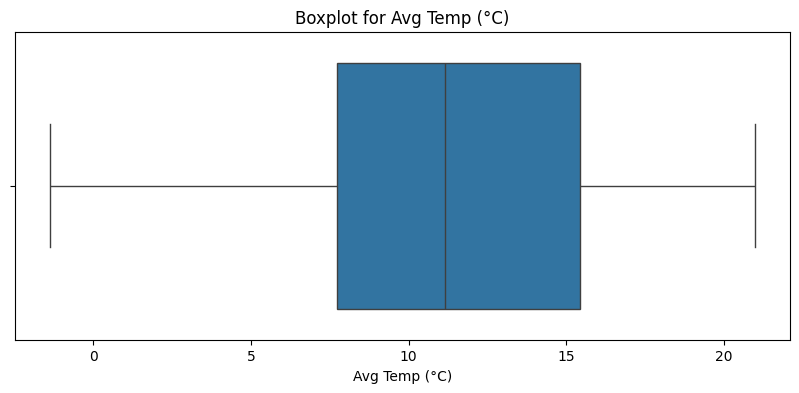

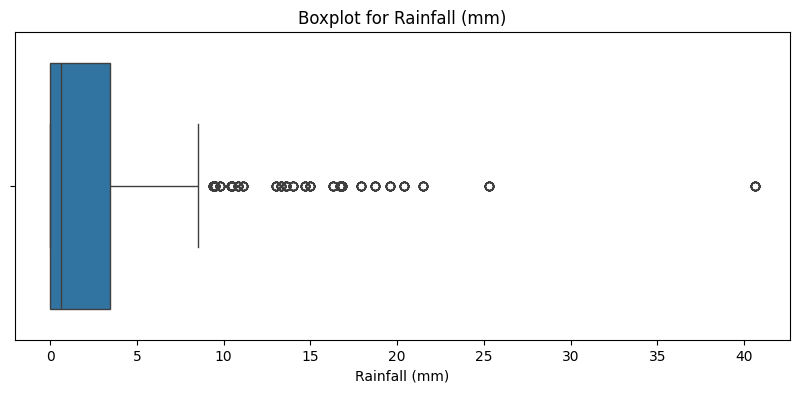

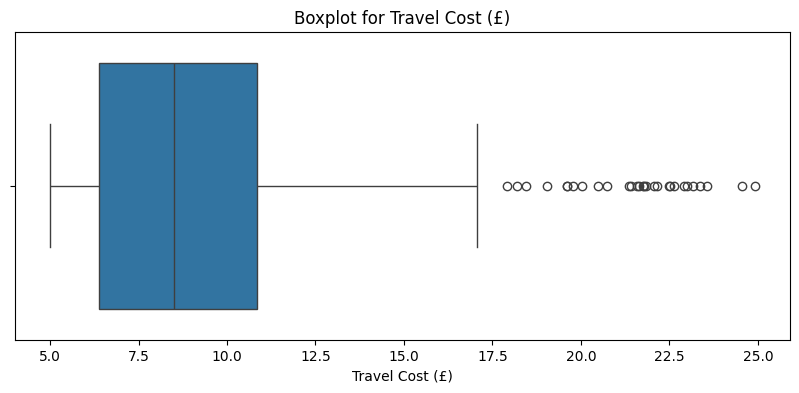


Original features with skewness greater than 1 or less than -1:
Rainfall (mm)      3.227361
Travel Cost (£)    1.198505
dtype: float64

Number of outliers per original feature after clipping:
Avg Temp (°C): 0 outliers
Rainfall (mm): 0 outliers
Travel Cost (£): 0 outliers

Class distribution for Morning Shift Work Location:
Morning Shift Work Location
office    2136
home       724
Name: count, dtype: int64


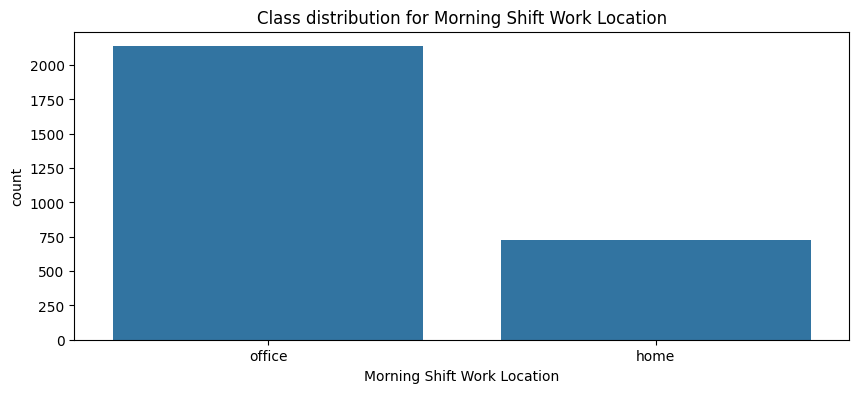


Class distribution for Afternoon Shift Work Location:
Afternoon Shift Work Location
office    1962
home       898
Name: count, dtype: int64


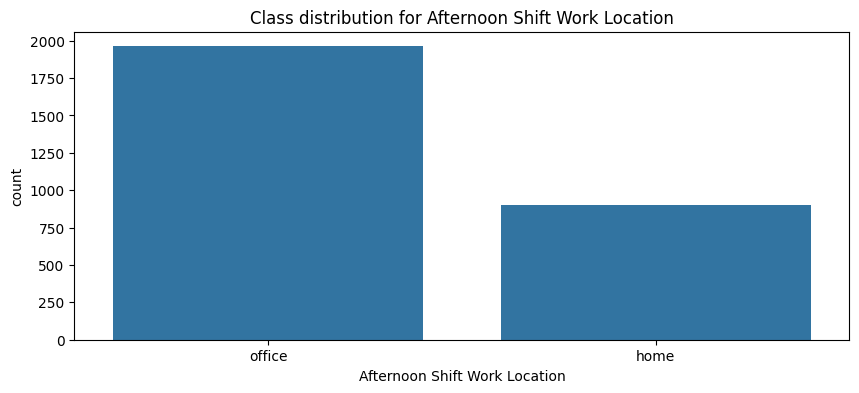


Gradient Boosting Classifier Accuracy:
Train Accuracy for Morning Shift Work Location: 0.8592657342657343
Train Accuracy for Afternoon Shift Work Location: 0.8675699300699301
Test Accuracy for Morning Shift Work Location: 0.8583916083916084
Test Accuracy for Afternoon Shift Work Location: 0.8548951048951049
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

AdaBoost Classifier Accuracy:
Train Accuracy for Morning Shift Work Location: 0.8422202797202797
Train Accuracy for Afternoon Shift Work Location: 0.8575174825174825
Test Accuracy for Morning Shift Work Location: 0.8444055944055944
Test Accuracy fo

['pipeline_stacking.joblib']

In [3]:
# Load dataset from a CSV file
data = pd.read_csv('simulated_data_new.csv')

# Convert 'Date' column to datetime format and extract temporal features
data['Date'] = pd.to_datetime(data['Date'])
data['Day_of_Week'] = data['Date'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
data['Month'] = data['Date'].dt.month  # Extract month (1=January, 12=December)
data['Day_of_Month'] = data['Date'].dt.day  # Extract day of the month
data['Quarter'] = data['Date'].dt.quarter  # Extract quarter of the year (1, 2, 3, or 4)
data['Is_Weekend'] = (data['Date'].dt.dayofweek >= 5).astype(int)  # Binary indicator for weekends

# Drop the original 'Date' column as it is no longer needed
data = data.drop(columns=['Date'])

# Rename column to correct encoding issue
data = data.rename(columns={'Avg Temp (Â°C)': 'Avg Temp (°C)'})

# Save original columns for outlier and skewness checks
original_columns = ['Radiologist ID', 'Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)', 'Internet Issues at Home', 'Trainee Assigned', 'Supervised Session', 'Cold Session', 'Admin Work']
original_data = data[original_columns + ['Morning Shift Work Location', 'Afternoon Shift Work Location']]

# Create interaction features
data['Month_Rain_Interaction'] = data['Month'] * data['Rainfall (mm)']  # Interaction between month and rainfall
data['Weekend_Travel_Interaction'] = data['Is_Weekend'] * data['Travel Cost (£)']  # Interaction between weekend and travel cost
data['Rainfall_travel'] = data['Rainfall (mm)'] * data['Travel Cost (£)']  # Interaction between rainfall and travel cost
data['Avg_temp_travel'] = data['Avg Temp (°C)'] * data['Travel Cost (£)']  # Interaction between average temperature and travel cost
data['Weeked_Avg_Temp_Interaction'] = data['Is_Weekend'] * data['Avg Temp (°C)']  # Interaction between weekend and average temperature

# Function to check for outliers using IQR (Interquartile Range)
def detect_outliers_iqr(df, columns):
    outliers = {}
    for column in columns:
        if df[column].dtype in ['float64', 'int64']:  # Only process numerical columns
            Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
            Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
            IQR = Q3 - Q1  # Interquartile Range
            lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
            upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers
            outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]  # Count of outliers
    return outliers

# Function to plot boxplots for outlier detection
def plot_boxplots(df, columns):
    for column in columns:
        if df[column].dtype in ['float64', 'int64']:  # Only process numerical columns
            plt.figure(figsize=(10, 4))
            sns.boxplot(x=df[column])
            plt.title(f'Boxplot for {column}')
            plt.show()

# Function to check skewness of numerical columns
def check_skewness(df, columns):
    skewness = df[columns].select_dtypes(include=['float64', 'int64']).apply(lambda x: skew(x.dropna()))  # Calculate skewness
    return skewness[abs(skewness) > 1]  # Return features with skewness > 1 or < -1

# Function to check class imbalance by plotting distribution
def check_class_imbalance(df, columns):
    for column in columns:
        print(f"\nClass distribution for {column}:")
        print(df[column].value_counts())  # Print class distribution
        plt.figure(figsize=(10, 4))
        sns.countplot(x=df[column])
        plt.title(f'Class distribution for {column}')
        plt.show()

# Check for outliers in the original columns
outliers = detect_outliers_iqr(original_data, original_columns)
print("Number of outliers per original feature:")
for feature, count in outliers.items():
    print(f"{feature}: {count} outliers")

# Plot boxplots to visualize outliers for original columns
plot_boxplots(original_data, original_columns)

# Check for skewness in the original columns
skewness = check_skewness(original_data, original_columns)
print("\nOriginal features with skewness greater than 1 or less than -1:")
print(skewness)

# Optional: Clip outliers (remove them) from original data
def clip_outliers(df, columns):
    # Make a copy of the DataFrame to avoid modifying the original DataFrame directly
    df = df.copy()

    for column in columns:
        if df[column].dtype in ['float64', 'int64']:  # Only process numerical columns
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # Clip values to within the bounds
            df.loc[:, column] = np.clip(df[column], lower_bound, upper_bound)

    return df

# Clip outliers from original data
original_data_clipped = clip_outliers(original_data, original_columns)

# Re-check for outliers after clipping
outliers_clipped = detect_outliers_iqr(original_data_clipped, original_columns)
print("\nNumber of outliers per original feature after clipping:")
for feature, count in outliers_clipped.items():
    print(f"{feature}: {count} outliers")

# Check class imbalance in shift work locations
check_class_imbalance(data, ['Morning Shift Work Location', 'Afternoon Shift Work Location'])

# Encode categorical features using OneHotEncoder
internet_issues_encoder = OneHotEncoder(sparse_output=False)
internet_issues_encoded = internet_issues_encoder.fit_transform(data[['Internet Issues at Home']])
internet_issues_encoded_df = pd.DataFrame(internet_issues_encoded, columns=internet_issues_encoder.get_feature_names_out(['Internet Issues at Home']))

radiologist_encoder = OneHotEncoder(sparse_output=False)
radiologist_encoded = radiologist_encoder.fit_transform(data[['Radiologist ID']])
radiologist_encoded_df = pd.DataFrame(radiologist_encoded, columns=radiologist_encoder.get_feature_names_out(['Radiologist ID']))

trainee_assigned_encoder = OneHotEncoder(sparse_output=False)
trainee_assigned_encoded = trainee_assigned_encoder.fit_transform(data[['Trainee Assigned']])
trainee_assigned_encoded_df = pd.DataFrame(trainee_assigned_encoded, columns=trainee_assigned_encoder.get_feature_names_out(['Trainee Assigned']))

supervised_session_encoder = OneHotEncoder(sparse_output=False)
supervised_session_encoded = supervised_session_encoder.fit_transform(data[['Supervised Session']])
supervised_session_encoded_df = pd.DataFrame(supervised_session_encoded, columns=supervised_session_encoder.get_feature_names_out(['Supervised Session']))

cold_session_encoder = OneHotEncoder(sparse_output=False)
cold_session_encoded = cold_session_encoder.fit_transform(data[['Cold Session']])
cold_session_encoded_df = pd.DataFrame(cold_session_encoded, columns=cold_session_encoder.get_feature_names_out(['Cold Session']))

admin_work_encoder = OneHotEncoder(sparse_output=False)
admin_work_encoded = admin_work_encoder.fit_transform(data[['Admin Work']])
admin_work_encoded_df = pd.DataFrame(admin_work_encoded, columns=admin_work_encoder.get_feature_names_out(['Admin Work']))

# Concatenate encoded features back to the original dataframe
data = pd.concat([data, internet_issues_encoded_df, radiologist_encoded_df, trainee_assigned_encoded_df, supervised_session_encoded_df, cold_session_encoded_df, admin_work_encoded_df], axis=1)

# Create additional interaction features based on encoded variables
# Create an empty list to collect DataFrames with interaction features
interaction_dfs = []

# For Radiologist encoded columns
for radiologist_col in radiologist_encoded_df.columns:
    for feature in ['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)', 'Weekend_Travel_Interaction'] + list(internet_issues_encoded_df.columns) + list(supervised_session_encoded_df.columns) + list(admin_work_encoded_df.columns):
        interaction_df = pd.DataFrame({
            f'{radiologist_col}_{feature}_Interaction': radiologist_encoded_df[radiologist_col] * data[feature]
        })
        interaction_dfs.append(interaction_df)

# For Cold Session encoded columns
for cold_col in cold_session_encoded_df.columns:
    for feature in list(admin_work_encoded_df.columns) + list(supervised_session_encoded_df.columns) + list(trainee_assigned_encoded_df.columns):
        interaction_df = pd.DataFrame({
            f'{cold_col}_{feature}_Interaction': cold_session_encoded_df[cold_col] * data[feature]
        })
        interaction_dfs.append(interaction_df)

# For Supervised Session encoded columns
for supervised_col in supervised_session_encoded_df.columns:
    for feature in ['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)'] + list(admin_work_encoded_df.columns) + list(trainee_assigned_encoded_df.columns):
        interaction_df = pd.DataFrame({
            f'{supervised_col}_{feature}_Interaction': supervised_session_encoded_df[supervised_col] * data[feature]
        })
        interaction_dfs.append(interaction_df)

# For Admin Work encoded columns
for admin_col in admin_work_encoded_df.columns:
    for feature in ['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)']+list(internet_issues_encoded_df.columns):
        interaction_df = pd.DataFrame({
            f'{admin_col}_{feature}_Interaction': admin_work_encoded_df[admin_col] * data[feature]
        })
        interaction_dfs.append(interaction_df)

# Concatenate all interaction DataFrames into one
interaction_features = pd.concat(interaction_dfs, axis=1)

# Concatenate interaction features with the original data
data = pd.concat([data, interaction_features], axis=1)

# Drop the original categorical columns as they have been encoded
data = data.drop(columns=['Radiologist ID', 'Internet Issues at Home', 'Trainee Assigned', 'Supervised Session', 'Cold Session', 'Admin Work'])


# Separate features and target variables
X = data.drop(columns=['Morning Shift Work Location', 'Afternoon Shift Work Location'])  # Feature set
y = data[['Morning Shift Work Location', 'Afternoon Shift Work Location']]  # Target variables

# Define preprocessing for numerical and categorical features (no categorical features left)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), [])  # Placeholder, no categorical features left
    ],
    remainder='passthrough'  # Pass through remaining features without changes
)

# Define a pipeline with preprocessing and classifier
def create_pipeline(base_model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', base_model)
    ])

# Split data into training and testing sets
split_index = int(len(X) * 0.8)  # Use 80% of data for training and 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 1. Gradient Boosting with MultiOutputClassifier
gbm_model = GradientBoostingClassifier()
multioutput_gbm_model = MultiOutputClassifier(gbm_model)
pipeline_gbm = create_pipeline(multioutput_gbm_model)
pipeline_gbm.fit(X_train, y_train)
y_pred_gbm = pipeline_gbm.predict(X_test)

print("\nGradient Boosting Classifier Accuracy:")
print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], pipeline_gbm.predict(X_train)[:, 0]))
print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], pipeline_gbm.predict(X_train)[:, 1]))
print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_gbm[:, 0]))
print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_gbm[:, 1]))
print(gbm_model.get_params())
# Save the trained Gradient Boosting model
joblib.dump(pipeline_gbm, 'pipeline_gbm.joblib')

# 2. AdaBoost Classifier
ada_model = AdaBoostClassifier(n_estimators=100)
multioutput_ada_model = MultiOutputClassifier(ada_model)
pipeline_ada = create_pipeline(multioutput_ada_model)
pipeline_ada.fit(X_train, y_train)
y_pred_ada = pipeline_ada.predict(X_test)

print("\nAdaBoost Classifier Accuracy:")
print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], pipeline_ada.predict(X_train)[:, 0]))
print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], pipeline_ada.predict(X_train)[:, 1]))
print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_ada[:, 0]))
print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_ada[:, 1]))
print(ada_model.get_params())
# Save the trained AdaBoost model
joblib.dump(pipeline_ada, 'pipeline_ada.joblib')

#3. RF Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=10,              # Limit the depth of each tree
    min_samples_split=5,       # Minimum samples required to split a node
    min_samples_leaf=2,        # Minimum samples required at each leaf node
    max_features='sqrt'        # Number of features to consider when looking for the best split
)

multioutput_rf_model = MultiOutputClassifier(rf_model)

# Assuming create_pipeline is a function that creates the pipeline (e.g., with preprocessing steps)
pipeline_rf = create_pipeline(multioutput_rf_model)

# Fit the model
pipeline_rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate the model
print("\nRandom Forest Classifier Accuracy:")
print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], pipeline_rf.predict(X_train)[:, 0]))
print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], pipeline_rf.predict(X_train)[:, 1]))
print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_rf[:, 0]))
print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_rf[:, 1]))

# Save the trained Random Forest model
joblib.dump(pipeline_rf, 'pipeline_rf.joblib')

# 4. Stacking Classifier
# Define base models for stacking
base_models = [
    ('gbm', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier(n_estimators=100)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,max_features='sqrt'))
]

# Define the stacking model
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression())


multioutput_stacking_model = MultiOutputClassifier(stacking_model)
pipeline_stacking = create_pipeline(multioutput_stacking_model)
pipeline_stacking.fit(X_train, y_train)
y_pred_stacking = pipeline_stacking.predict(X_test)

print("\nStacking Classifier Accuracy:")
print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], pipeline_stacking.predict(X_train)[:, 0]))
print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], pipeline_stacking.predict(X_train)[:, 1]))
print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_stacking[:, 0]))
print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_stacking[:, 1]))

# Save the trained Stacking model
joblib.dump(pipeline_stacking, 'pipeline_stacking.joblib')


<Figure size 800x600 with 0 Axes>

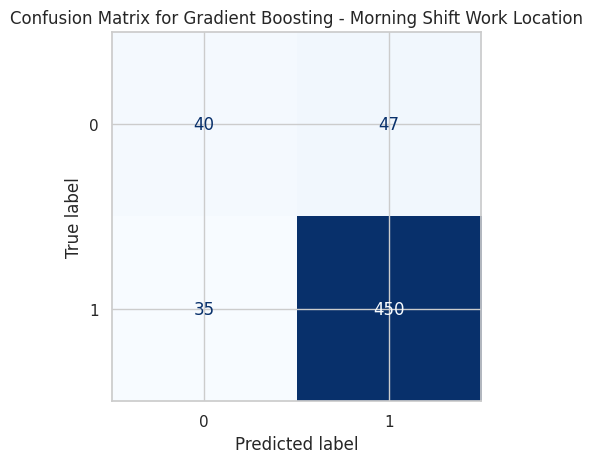

<Figure size 800x600 with 0 Axes>

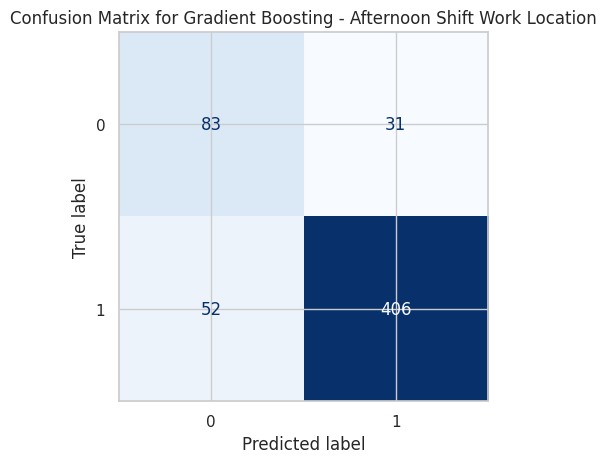

<Figure size 800x600 with 0 Axes>

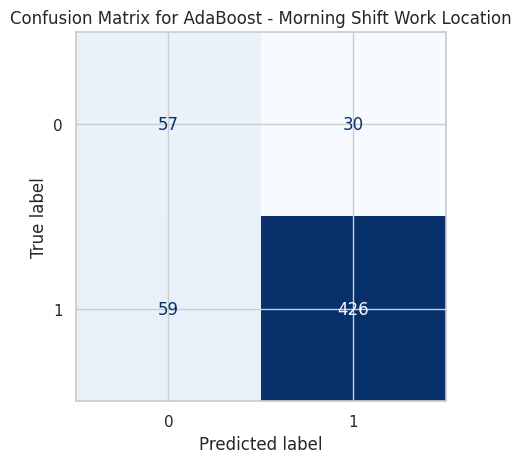

<Figure size 800x600 with 0 Axes>

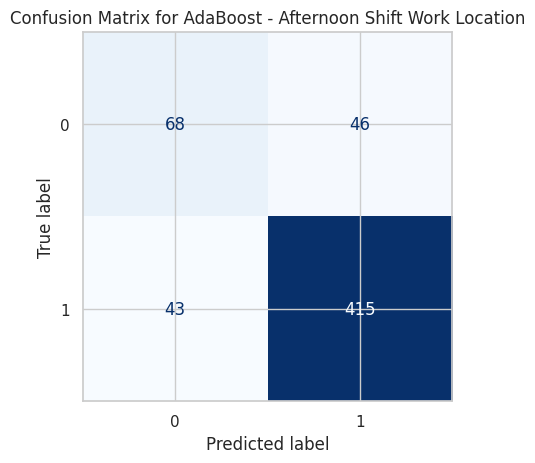

<Figure size 800x600 with 0 Axes>

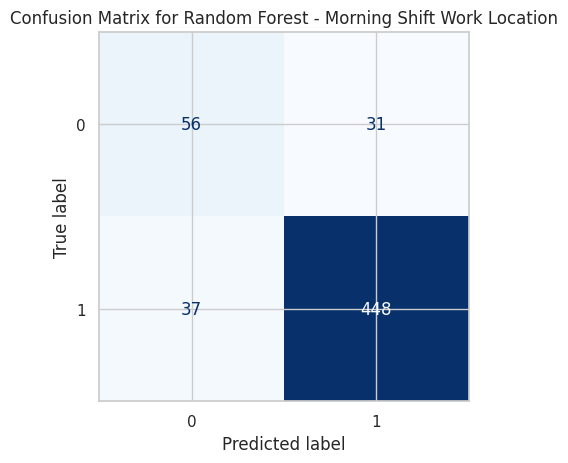

<Figure size 800x600 with 0 Axes>

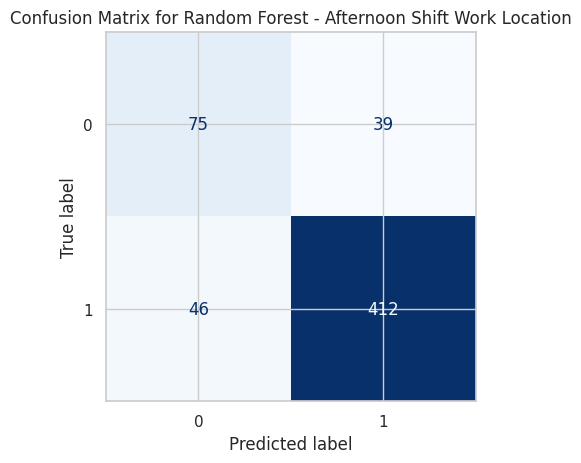

<Figure size 800x600 with 0 Axes>

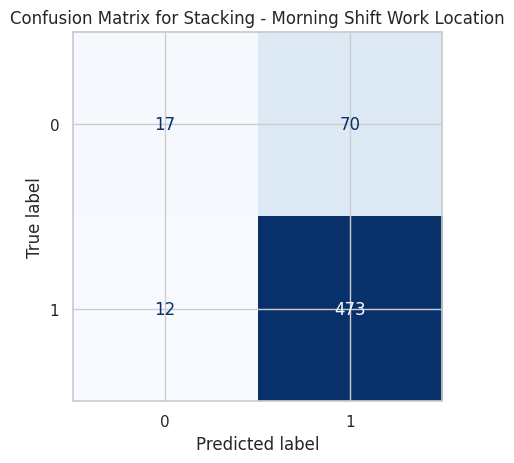

<Figure size 800x600 with 0 Axes>

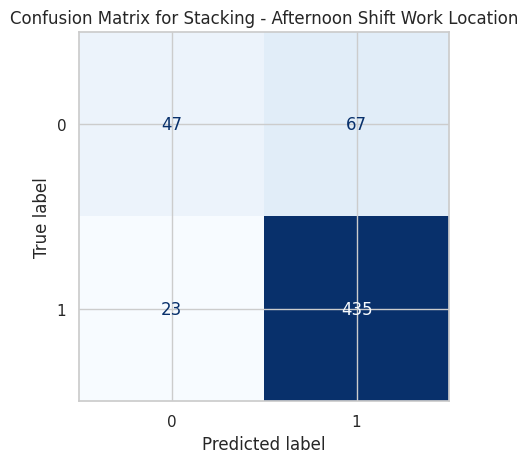

In [47]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained models
pipeline_gbm = joblib.load('pipeline_gbm.joblib')
pipeline_ada = joblib.load('pipeline_ada.joblib')
pipeline_rf = joblib.load('pipeline_rf.joblib')
pipeline_stacking = joblib.load('pipeline_stacking.joblib')

# List of models and their names
models = {
    'Gradient Boosting': pipeline_gbm,
    'AdaBoost': pipeline_ada,
    'Random Forest': pipeline_rf,
    'Stacking': pipeline_stacking
}

# Function to plot confusion matrix for each target variable
def plot_confusion_matrices(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)

    for i, col in enumerate(y_test.columns):
        cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        disp.plot(cmap='Blues', colorbar=False)
        plt.title(f'Confusion Matrix for {model_name} - {col}')
        plt.show()

# Plot confusion matrices for all models
for name, model in models.items():
    plot_confusion_matrices(model, X_test, y_test, name)



Target Variable: Morning Shift Work Location
Gradient Boosting AUC for Morning Shift Work Location: 0.93
AdaBoost AUC for Morning Shift Work Location: 0.91
Random Forest AUC for Morning Shift Work Location: 0.92
Stacking AUC for Morning Shift Work Location: 0.87

Target Variable: Afternoon Shift Work Location
Gradient Boosting AUC for Afternoon Shift Work Location: 0.91
AdaBoost AUC for Afternoon Shift Work Location: 0.90
Random Forest AUC for Afternoon Shift Work Location: 0.87
Stacking AUC for Afternoon Shift Work Location: 0.85


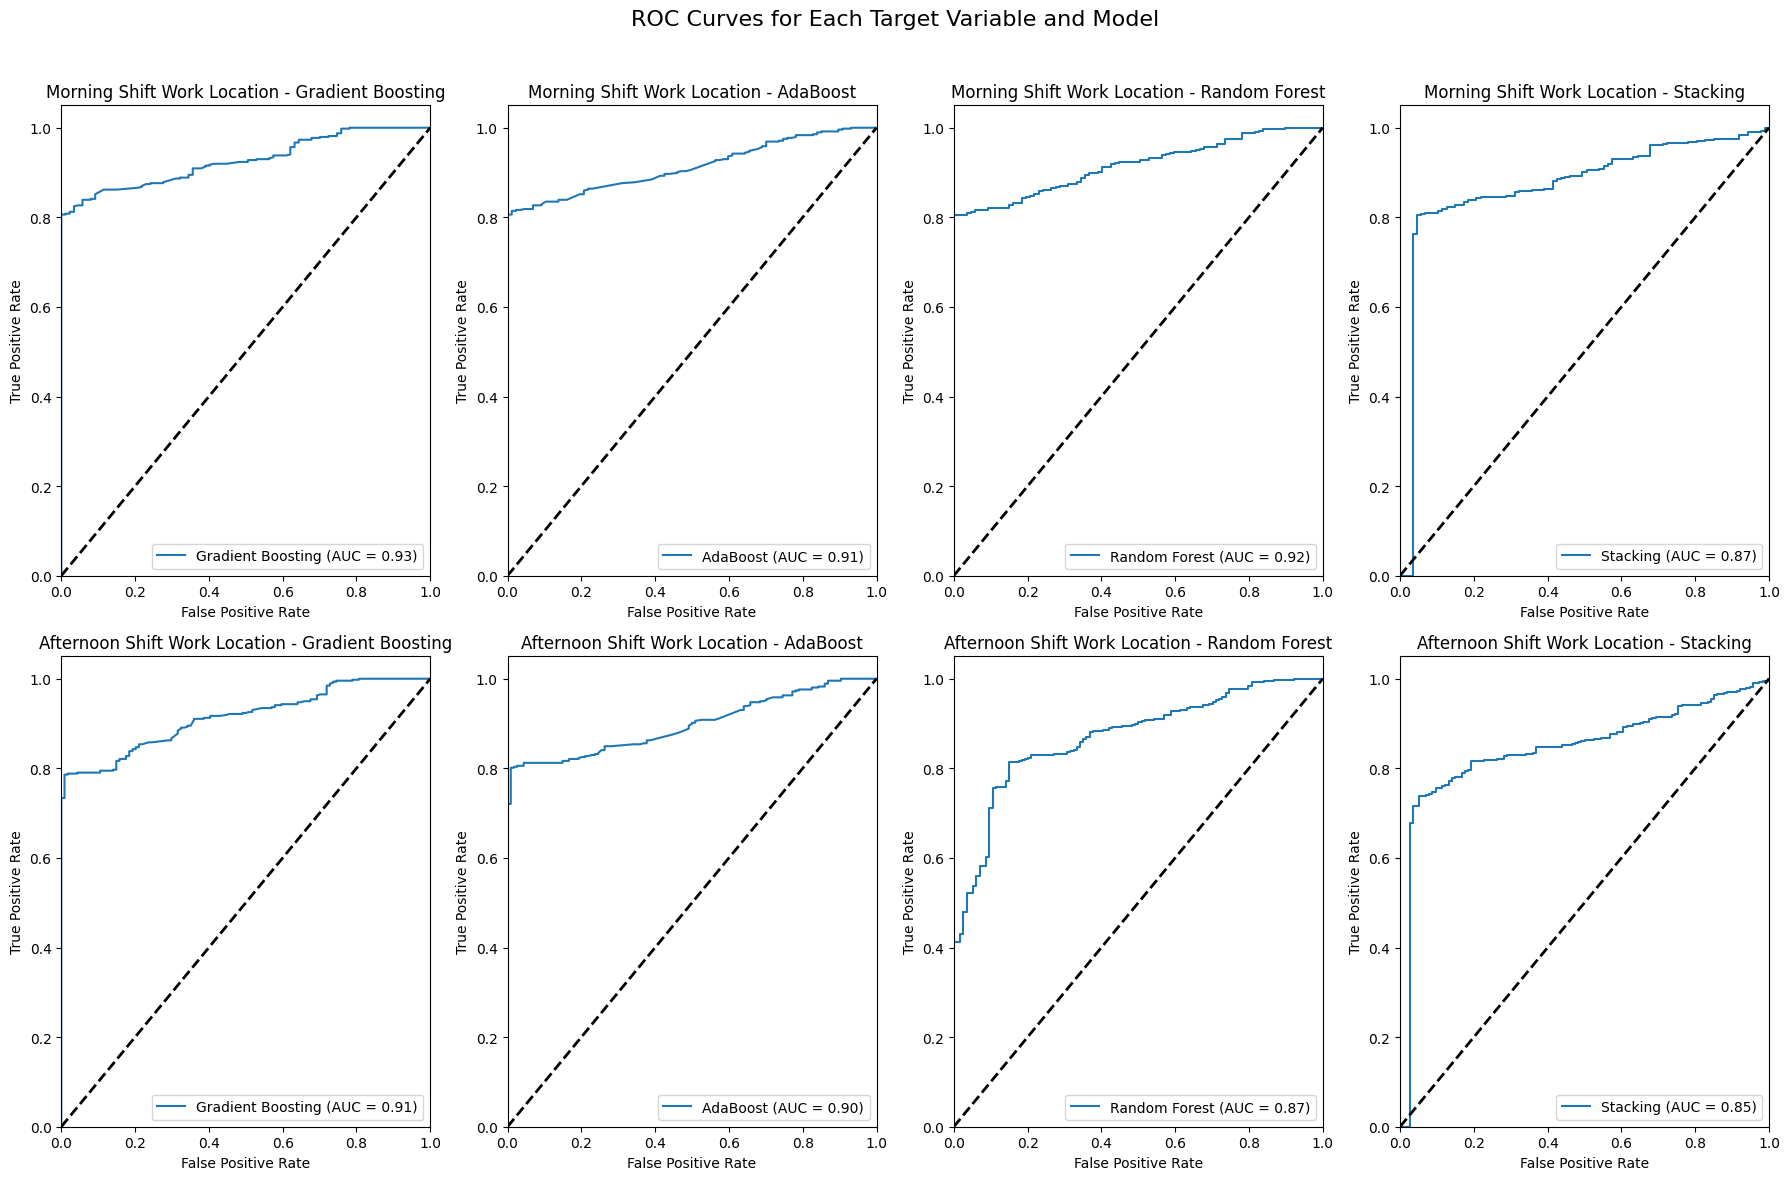

In [4]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the saved models
pipeline_gbm = joblib.load('pipeline_gbm.joblib')
pipeline_ada = joblib.load('pipeline_ada.joblib')
pipeline_rf = joblib.load('pipeline_rf.joblib')
pipeline_stacking = joblib.load('pipeline_stacking.joblib')

# Define the models and their names
models = {
    'Gradient Boosting': pipeline_gbm,
    'AdaBoost': pipeline_ada,
    'Random Forest': pipeline_rf,
    'Stacking': pipeline_stacking
}

# Create a figure for ROC curves
fig, axes = plt.subplots(nrows=len(y_train.columns), ncols=len(models), figsize=(18, 12))
fig.suptitle('ROC Curves for Each Target Variable and Model', fontsize=16)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Iterate through each target variable
for i, target in enumerate(y_train.columns):
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    # Binarize the target variable
    y_train_binarized = label_binarize(y_train_target, classes=np.unique(y_train_target))
    y_test_binarized = label_binarize(y_test_target, classes=np.unique(y_test_target))

    print(f"\nTarget Variable: {target}")

    # Iterate through each model
    for j, (name, model) in enumerate(models.items()):
        # Predict probabilities for the current target variable
        y_prob = model.predict_proba(X_test)  # Assuming model.predict_proba works for all models

        # Calculate ROC curve and AUC for the current target variable
        fpr, tpr, _ = roc_curve(y_test_binarized, y_prob[0][:, 1])
        roc_auc = auc(fpr, tpr)

        # Print AUC score
        print(f"{name} AUC for {target}: {roc_auc:.2f}")

        # Plot ROC curve
        axes[i * len(models) + j].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        axes[i * len(models) + j].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[i * len(models) + j].set_xlim([0.0, 1.0])
        axes[i * len(models) + j].set_ylim([0.0, 1.05])
        axes[i * len(models) + j].set_xlabel('False Positive Rate')
        axes[i * len(models) + j].set_ylabel('True Positive Rate')
        axes[i * len(models) + j].set_title(f'{target} - {name}')
        axes[i * len(models) + j].legend(loc='lower right')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [44]:
import optuna

# Further split X_train and y_train into training and validation sets
split_index_val = int(len(X_train) * 0.9)  # Use 90% of X_train for training and 10% for validation
X_train_final, X_val = X_train[:split_index_val], X_train[split_index_val:]
y_train_final, y_val = y_train[:split_index_val], y_train[split_index_val:]

from optuna.samplers import TPESampler


# Define the objective function for Gradient Boosting
def objective_gbm(trial):
    gbm_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log= True),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    gbm_model = GradientBoostingClassifier(**gbm_params)
    multioutput_gbm_model = MultiOutputClassifier(gbm_model)
    pipeline_gbm = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', multioutput_gbm_model)
    ])

    pipeline_gbm.fit(X_train_final, y_train_final)
    y_pred_val = pipeline_gbm.predict(X_val)

    accuracy = (accuracy_score(y_val.iloc[:, 0], y_pred_val[:, 0]) +
                accuracy_score(y_val.iloc[:, 1], y_pred_val[:, 1])) / 2
    return accuracy

# Define the objective function for AdaBoost
def objective_ada(trial):
    ada_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log= True)
    }

    ada_model = AdaBoostClassifier(**ada_params)
    multioutput_ada_model = MultiOutputClassifier(ada_model)
    pipeline_ada = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', multioutput_ada_model)
    ])

    pipeline_ada.fit(X_train_final, y_train_final)
    y_pred_val = pipeline_ada.predict(X_val)

    accuracy = (accuracy_score(y_val.iloc[:, 0], y_pred_val[:, 0]) +
                accuracy_score(y_val.iloc[:, 1], y_pred_val[:, 1])) / 2
    return accuracy

# Define the objective function for Random Forest
def objective_rf(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    rf_model = RandomForestClassifier(**rf_params)
    multioutput_rf_model = MultiOutputClassifier(rf_model)
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', multioutput_rf_model)
    ])

    pipeline_rf.fit(X_train_final, y_train_final)
    y_pred_val = pipeline_rf.predict(X_val)

    accuracy = (accuracy_score(y_val.iloc[:, 0], y_pred_val[:, 0]) +
                accuracy_score(y_val.iloc[:, 1], y_pred_val[:, 1])) / 2
    return accuracy

# Define the objective function for Stacking Classifier
def objective_stack(trial):
    gbm_params = {
        'n_estimators': trial.suggest_int('gbm_n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('gbm_learning_rate', 1e-3, 1e-1,log=True),
        'max_depth': trial.suggest_int('gbm_max_depth', 3, 10)
    }

    ada_params = {
        'n_estimators': trial.suggest_int('ada_n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('ada_learning_rate', 1e-3, 1e-1,log=True)
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 200),
        'max_depth': trial.suggest_int('rf_max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    }

    gbm_model = GradientBoostingClassifier(**gbm_params)
    ada_model = AdaBoostClassifier(**ada_params)
    rf_model = RandomForestClassifier(**rf_params)

    stacking_model = StackingClassifier(
        estimators=[
            ('gbm', gbm_model),
            ('ada', ada_model),
            ('rf', rf_model)
        ],
        final_estimator=LogisticRegression()
    )

    multioutput_stacking_model = MultiOutputClassifier(stacking_model)
    pipeline_stacking = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', multioutput_stacking_model)
    ])

    pipeline_stacking.fit(X_train_final, y_train_final)
    y_pred_val = pipeline_stacking.predict(X_val)

    accuracy = (accuracy_score(y_val.iloc[:, 0], y_pred_val[:, 0]) +
                accuracy_score(y_val.iloc[:, 1], y_pred_val[:, 1])) / 2
    return accuracy


# Optimize models using Optuna
def optimize_model(objective_func, model_name):
    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(objective_func, n_trials=50)  # Adjust n_trials as needed
    print(f"Best parameters for {model_name}:")
    print(study.best_params)
    return study, study.best_params

# Perform optimization and get the study objects
study_gbm, best_gbm_params = optimize_model(objective_gbm, 'Gradient Boosting')
study_ada, best_ada_params = optimize_model(objective_ada, 'AdaBoost')
study_rf, best_rf_params = optimize_model(objective_rf, 'Random Forest')
study_stack, best_stack_params = optimize_model(objective_stack, 'Stacking')

# Train and save the best Gradient Boosting model
gbm_model = GradientBoostingClassifier(**best_gbm_params)
multioutput_gbm_model = MultiOutputClassifier(gbm_model)
pipeline_gbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', multioutput_gbm_model)
])
pipeline_gbm.fit(X_train, y_train)
joblib.dump(pipeline_gbm, 'best_pipeline_gbm.joblib')

# Train and save the best AdaBoost model
ada_model = AdaBoostClassifier(**best_ada_params)
multioutput_ada_model = MultiOutputClassifier(ada_model)
pipeline_ada = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', multioutput_ada_model)
])
pipeline_ada.fit(X_train, y_train)
joblib.dump(pipeline_ada, 'best_pipeline_ada.joblib')

# Train and save the best Random Forest model
rf_model = RandomForestClassifier(**best_rf_params)
multioutput_rf_model = MultiOutputClassifier(rf_model)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', multioutput_rf_model)
])
pipeline_rf.fit(X_train, y_train)
joblib.dump(pipeline_rf, 'best_pipeline_rf.joblib')

# Train and save the best Stacking model

gbm_model = GradientBoostingClassifier(
    n_estimators=best_stack_params['gbm_n_estimators'],
    learning_rate=best_stack_params['gbm_learning_rate'],
    max_depth=best_stack_params['gbm_max_depth']
)
ada_model = AdaBoostClassifier(
    n_estimators=best_stack_params['ada_n_estimators'],
    learning_rate=best_stack_params['ada_learning_rate']
)
rf_model = RandomForestClassifier(
    n_estimators=best_stack_params['rf_n_estimators'],
    max_depth=best_stack_params['rf_max_depth'],
    min_samples_split=best_stack_params['rf_min_samples_split'],
    min_samples_leaf=best_stack_params['rf_min_samples_leaf'],
    max_features=best_stack_params['rf_max_features']
)
stacking_model = StackingClassifier(
    estimators=[
        ('gbm', gbm_model),
        ('ada', ada_model),
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression()
)
multioutput_stacking_model = MultiOutputClassifier(stacking_model)
pipeline_stacking = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', multioutput_stacking_model)
])
pipeline_stacking.fit(X_train, y_train)
joblib.dump(pipeline_stacking, 'best_pipeline_stacking.joblib')

# Load the best models and test them on the test set
def evaluate_model(pipeline, X_test, y_test, model_name):
    y_pred_test = pipeline.predict(X_test)
    accuracy = (accuracy_score(y_test.iloc[:, 0], y_pred_test[:, 0]) +
                accuracy_score(y_test.iloc[:, 1], y_pred_test[:, 1])) / 2
    print(f"Test Accuracy for {model_name}: {accuracy}")

# Load and evaluate the models
pipeline_gbm = joblib.load('best_pipeline_gbm.joblib')
evaluate_model(pipeline_gbm, X_test, y_test, 'Gradient Boosting')

pipeline_ada = joblib.load('best_pipeline_ada.joblib')
evaluate_model(pipeline_ada, X_test, y_test, 'AdaBoost')

pipeline_rf = joblib.load('best_pipeline_rf.joblib')
evaluate_model(pipeline_rf, X_test, y_test, 'Random Forest')

pipeline_stacking = joblib.load('best_pipeline_stacking.joblib')
evaluate_model(pipeline_stacking, X_test, y_test, 'Stacking Classifier')



[I 2024-09-03 21:44:34,212] A new study created in memory with name: no-name-029a8465-215e-4fa1-b786-d4b330f7c302
[I 2024-09-03 21:44:36,739] Trial 0 finished with value: 0.8362445414847162 and parameters: {'n_estimators': 86, 'learning_rate': 0.01097559675227344, 'max_depth': 4}. Best is trial 0 with value: 0.8362445414847162.
[I 2024-09-03 21:44:38,301] Trial 1 finished with value: 0.851528384279476 and parameters: {'n_estimators': 63, 'learning_rate': 0.02556111696075174, 'max_depth': 3}. Best is trial 1 with value: 0.851528384279476.
[I 2024-09-03 21:44:48,048] Trial 2 finished with value: 0.8646288209606987 and parameters: {'n_estimators': 184, 'learning_rate': 0.0028317130197018634, 'max_depth': 8}. Best is trial 2 with value: 0.8646288209606987.
[I 2024-09-03 21:44:56,183] Trial 3 finished with value: 0.8646288209606987 and parameters: {'n_estimators': 165, 'learning_rate': 0.0035947057129422284, 'max_depth': 7}. Best is trial 2 with value: 0.8646288209606987.
[I 2024-09-03 21:4

Best parameters for Gradient Boosting:
{'n_estimators': 116, 'learning_rate': 0.04265872052941243, 'max_depth': 8}


[I 2024-09-03 21:50:54,776] Trial 0 finished with value: 0.8253275109170306 and parameters: {'n_estimators': 174, 'learning_rate': 0.0010840808607446178}. Best is trial 0 with value: 0.8253275109170306.
[I 2024-09-03 21:50:57,477] Trial 1 finished with value: 0.8253275109170306 and parameters: {'n_estimators': 125, 'learning_rate': 0.008075979131170974}. Best is trial 0 with value: 0.8253275109170306.
[I 2024-09-03 21:50:58,758] Trial 2 finished with value: 0.8253275109170306 and parameters: {'n_estimators': 60, 'learning_rate': 0.007893564714599057}. Best is trial 0 with value: 0.8253275109170306.
[I 2024-09-03 21:51:01,978] Trial 3 finished with value: 0.8406113537117904 and parameters: {'n_estimators': 151, 'learning_rate': 0.05231934662365321}. Best is trial 3 with value: 0.8406113537117904.
[I 2024-09-03 21:51:03,272] Trial 4 finished with value: 0.8253275109170306 and parameters: {'n_estimators': 60, 'learning_rate': 0.0022877596939238423}. Best is trial 3 with value: 0.840611353

Best parameters for AdaBoost:
{'n_estimators': 198, 'learning_rate': 0.07677386182347272}


[I 2024-09-03 21:54:01,184] Trial 0 finished with value: 0.8406113537117903 and parameters: {'n_estimators': 181, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8406113537117903.
[I 2024-09-03 21:54:02,435] Trial 1 finished with value: 0.8580786026200873 and parameters: {'n_estimators': 142, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8580786026200873.
[I 2024-09-03 21:54:03,672] Trial 2 finished with value: 0.8537117903930131 and parameters: {'n_estimators': 191, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8580786026200873.
[I 2024-09-03 21:54:04,913] Trial 3 finished with value: 0.8275109170305677 and parameters: {'n_estimators': 166, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8580786026200

Best parameters for Random Forest:
{'n_estimators': 166, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2024-09-03 21:55:39,945] Trial 0 finished with value: 0.8165938864628821 and parameters: {'gbm_n_estimators': 179, 'gbm_learning_rate': 0.01737588407233385, 'gbm_max_depth': 4, 'ada_n_estimators': 83, 'ada_learning_rate': 0.009734970283459063, 'rf_n_estimators': 155, 'rf_max_depth': 6, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 7, 'rf_max_features': 'log2'}. Best is trial 0 with value: 0.8165938864628821.
[I 2024-09-03 21:56:28,030] Trial 1 finished with value: 0.8056768558951966 and parameters: {'gbm_n_estimators': 121, 'gbm_learning_rate': 0.058441455731692384, 'gbm_max_depth': 6, 'ada_n_estimators': 75, 'ada_learning_rate': 0.011377697185413383, 'rf_n_estimators': 124, 'rf_max_depth': 20, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 3, 'rf_max_features': 'log2'}. Best is trial 0 with value: 0.8165938864628821.
[I 2024-09-03 21:57:27,196] Trial 2 finished with value: 0.8340611353711791 and parameters: {'gbm_n_estimators': 124, 'gbm_learning_rate': 0.014633002004085498,

Best parameters for Stacking:
{'gbm_n_estimators': 133, 'gbm_learning_rate': 0.005855356602529589, 'gbm_max_depth': 3, 'ada_n_estimators': 198, 'ada_learning_rate': 0.02226802065944055, 'rf_n_estimators': 120, 'rf_max_depth': 9, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 6, 'rf_max_features': 'log2'}
Test Accuracy for Gradient Boosting: 0.861013986013986
Test Accuracy for AdaBoost: 0.8496503496503496
Test Accuracy for Random Forest: 0.8583916083916083
Test Accuracy for Stacking Classifier: 0.8636363636363636


In [93]:
!pip install -U kaleido


In [45]:
import optuna.visualization as vis

# Plot optimization history for GBM
fig_gbm = vis.plot_optimization_history(study_gbm)
fig_gbm.show()  # Display the plot

# Plot optimization history for AdaBoost
fig_ada = vis.plot_optimization_history(study_ada)
fig_ada.show()  # Display the plot

# Plot optimization history for Random Forest
fig_rf = vis.plot_optimization_history(study_rf)
fig_rf.show()  # Display the plot

# Plot optimization history for Stacking Classifier
fig_stacking = vis.plot_optimization_history(study_stack)
fig_stacking.show()  # Display the plot


In [40]:
# Define dataset sizes to test
sizes = [0.2, 0.4, 0.6, 0.8, 0.99]  # Corresponding to 20%, 40%, 60%, 80%, and 100% of the dataset

for size in sizes:
    print(f"\nEvaluating models with {int(size * 100)}% of the dataset")

    # Use the specified percentage of the entire dataset
    X_subset, _, y_subset, _ = train_test_split(X, y, train_size=size, shuffle=False)

    # Perform an 80-20 split on this subset
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, train_size=0.8, shuffle=False)

    # Train and evaluate Gradient Boosting model
    gbm_model = GradientBoostingClassifier()
    multioutput_gbm_model = MultiOutputClassifier(gbm_model)
    pipeline_gbm = create_pipeline(multioutput_gbm_model)
    pipeline_gbm.fit(X_train, y_train)
    y_pred_gbm_train = pipeline_gbm.predict(X_train)
    y_pred_gbm_test = pipeline_gbm.predict(X_test)
    print("\nGradient Boosting Classifier Accuracy:")
    print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], y_pred_gbm_train[:, 0]))
    print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_gbm_test[:, 0]))
    print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], y_pred_gbm_train[:, 1]))
    print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_gbm_test[:, 1]))

    # Train and evaluate AdaBoost model
    ada_model = AdaBoostClassifier(n_estimators=100)
    multioutput_ada_model = MultiOutputClassifier(ada_model)
    pipeline_ada = create_pipeline(multioutput_ada_model)
    pipeline_ada.fit(X_train, y_train)
    y_pred_ada_train = pipeline_ada.predict(X_train)
    y_pred_ada_test = pipeline_ada.predict(X_test)
    print("\nAdaBoost Classifier Accuracy:")
    print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], y_pred_ada_train[:, 0]))
    print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_ada_test[:, 0]))
    print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], y_pred_ada_train[:, 1]))
    print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_ada_test[:, 1]))

    # Train and evaluate Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,max_features='sqrt')
    multioutput_rf_model = MultiOutputClassifier(rf_model)
    pipeline_rf = create_pipeline(multioutput_rf_model)
    pipeline_rf.fit(X_train, y_train)
    y_pred_rf_train = pipeline_rf.predict(X_train)
    y_pred_rf_test = pipeline_rf.predict(X_test)
    print("\nRandom Forest Classifier Accuracy:")
    print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], y_pred_rf_train[:, 0]))
    print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_rf_test[:, 0]))
    print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], y_pred_rf_train[:, 1]))
    print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_rf_test[:, 1]))

    # Train and evaluate Stacking model
    base_models = [
        ('gbm', GradientBoostingClassifier()),
        ('ada', AdaBoostClassifier(n_estimators=100)),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,max_features='sqrt'))
    ]
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
    multioutput_stacking_model = MultiOutputClassifier(stacking_model)
    pipeline_stacking = create_pipeline(multioutput_stacking_model)
    pipeline_stacking.fit(X_train, y_train)
    y_pred_stacking_train = pipeline_stacking.predict(X_train)
    y_pred_stacking_test = pipeline_stacking.predict(X_test)
    print("\nStacking Classifier Accuracy:")
    print("Train Accuracy for Morning Shift Work Location:", accuracy_score(y_train.iloc[:, 0], y_pred_stacking_train[:, 0]))
    print("Test Accuracy for Morning Shift Work Location:", accuracy_score(y_test.iloc[:, 0], y_pred_stacking_test[:, 0]))
    print("Train Accuracy for Afternoon Shift Work Location:", accuracy_score(y_train.iloc[:, 1], y_pred_stacking_train[:, 1]))
    print("Test Accuracy for Afternoon Shift Work Location:", accuracy_score(y_test.iloc[:, 1], y_pred_stacking_test[:, 1]))


Evaluating models with 20% of the dataset

Gradient Boosting Classifier Accuracy:
Train Accuracy for Morning Shift Work Location: 0.925601750547046
Test Accuracy for Morning Shift Work Location: 0.6782608695652174
Train Accuracy for Afternoon Shift Work Location: 0.9474835886214442
Test Accuracy for Afternoon Shift Work Location: 0.7565217391304347

AdaBoost Classifier Accuracy:
Train Accuracy for Morning Shift Work Location: 0.9431072210065645
Test Accuracy for Morning Shift Work Location: 0.6608695652173913
Train Accuracy for Afternoon Shift Work Location: 0.9584245076586433
Test Accuracy for Afternoon Shift Work Location: 0.7739130434782608

Random Forest Classifier Accuracy:
Train Accuracy for Morning Shift Work Location: 0.912472647702407
Test Accuracy for Morning Shift Work Location: 0.6608695652173913
Train Accuracy for Afternoon Shift Work Location: 0.8927789934354485
Test Accuracy for Afternoon Shift Work Location: 0.7391304347826086

Stacking Classifier Accuracy:
Train Accur

Plotting learning curves for Gradient Boosting Model


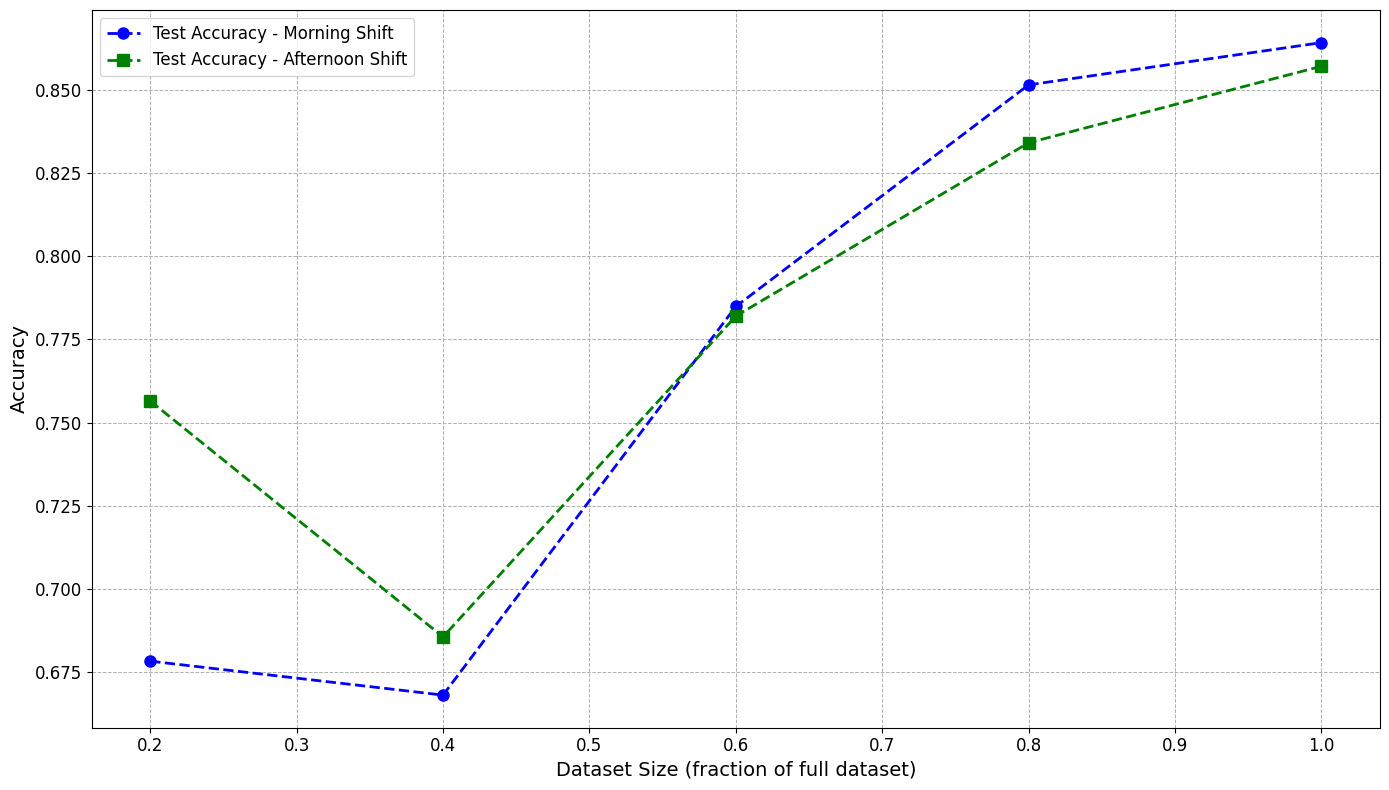

Plotting learning curves for AdaBoost Model


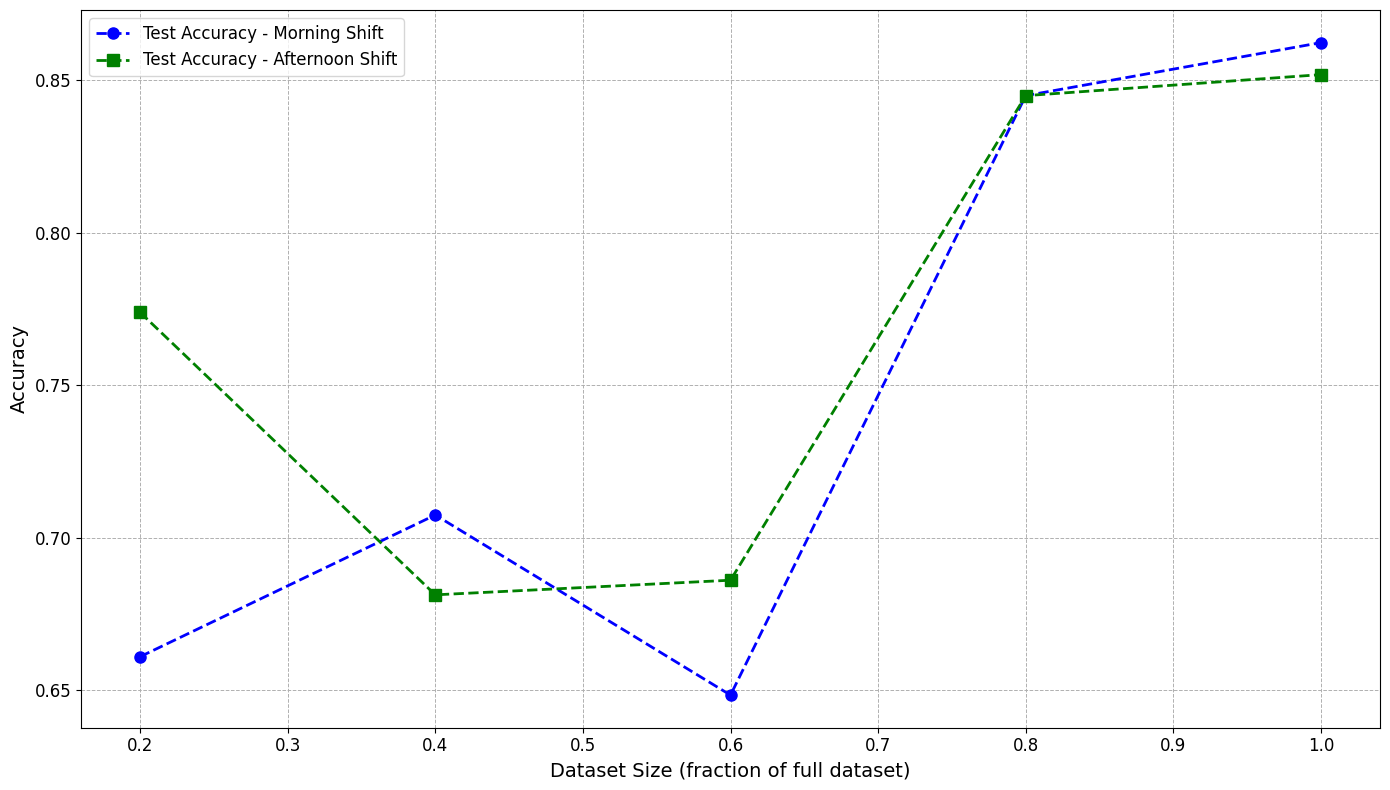

Plotting learning curves for Random Forest Model


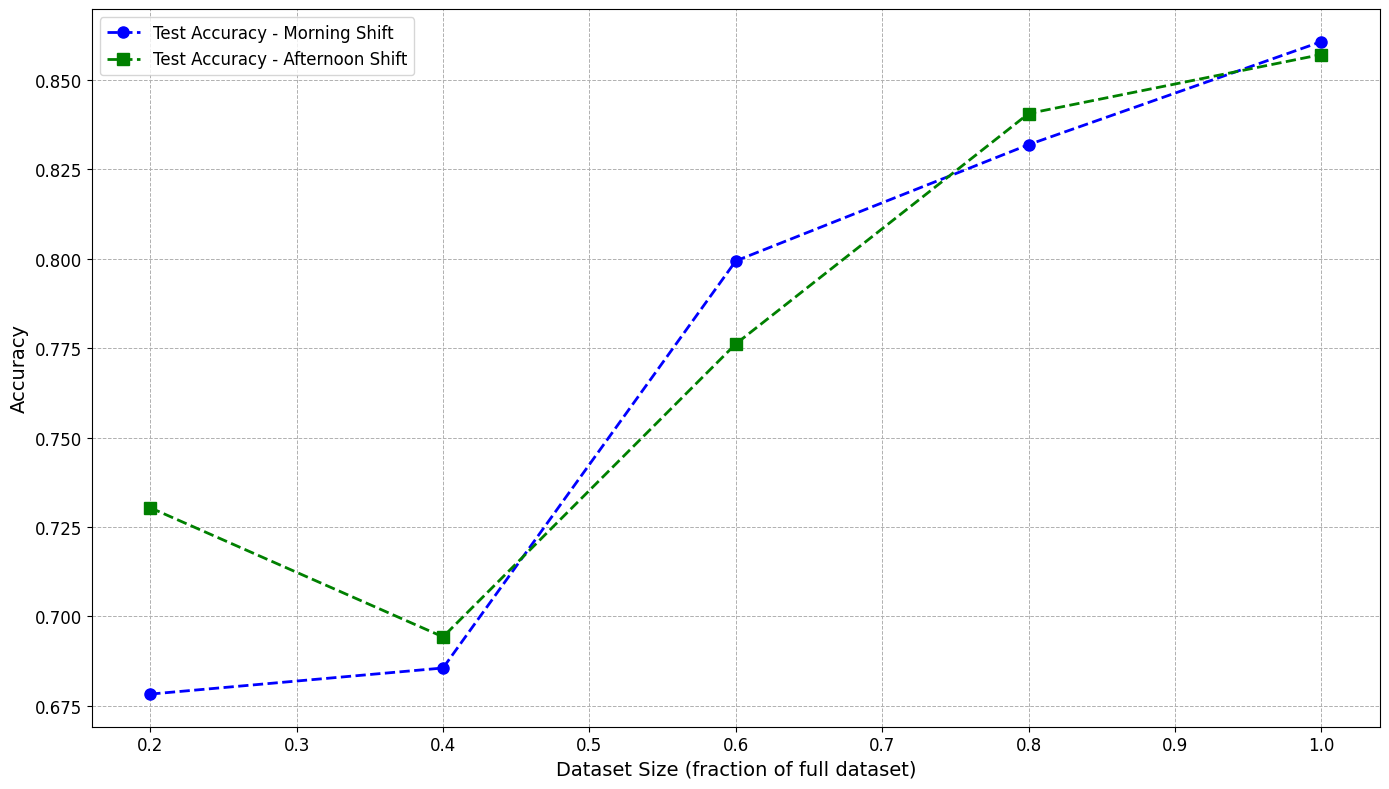

Plotting learning curves for Stacking Model


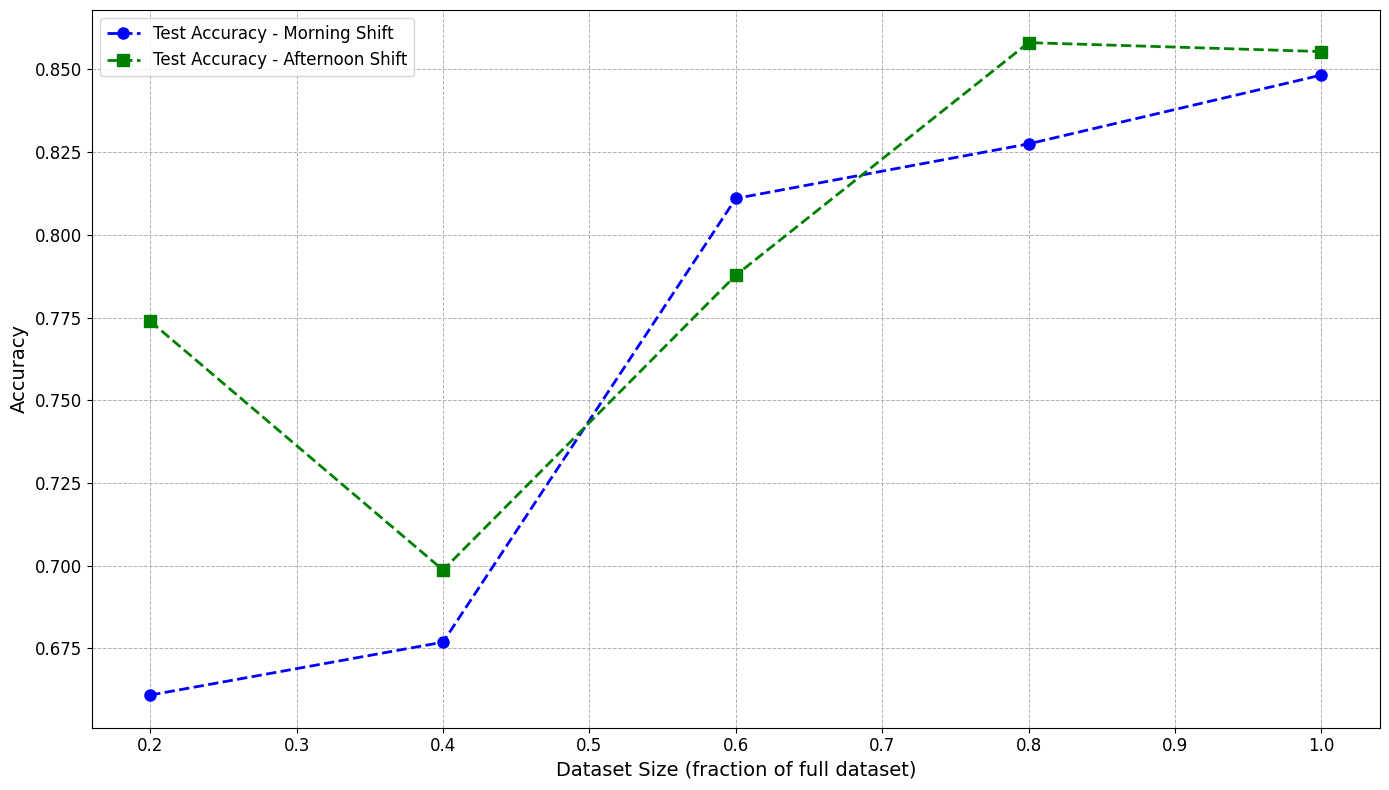

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Accuracy values for the different dataset sizes
data = {
    'Dataset_Size': [0.2, 0.4, 0.6, 0.8, 1.0],
    'Test_Accuracy_Morning': {
        'Gradient Boosting': [0.6783, 0.6681, 0.7849, 0.8515, 0.8642],
        'AdaBoost': [0.6609, 0.7074, 0.6483, 0.8450, 0.8624],
        'Random Forest': [0.6783, 0.6856, 0.7994, 0.8319, 0.8607],
        'Stacking': [0.6609, 0.6769, 0.8110, 0.8275, 0.8483]
    },
    'Test_Accuracy_Afternoon': {
        'Gradient Boosting': [0.7565, 0.6856, 0.7820, 0.8341, 0.8571],
        'AdaBoost': [0.7739, 0.6812, 0.6860, 0.8450, 0.8519],
        'Random Forest': [0.7304, 0.6943, 0.7762, 0.8406, 0.8571],
        'Stacking': [0.7739, 0.6987, 0.7878, 0.8581, 0.8554]
    }
}

# Create DataFrames for each model
results_gbm = pd.DataFrame({
    'Dataset_Size': data['Dataset_Size'],
    'Test_Accuracy_Morning': data['Test_Accuracy_Morning']['Gradient Boosting'],
    'Test_Accuracy_Afternoon': data['Test_Accuracy_Afternoon']['Gradient Boosting']
})

results_ada = pd.DataFrame({
    'Dataset_Size': data['Dataset_Size'],
    'Test_Accuracy_Morning': data['Test_Accuracy_Morning']['AdaBoost'],
    'Test_Accuracy_Afternoon': data['Test_Accuracy_Afternoon']['AdaBoost']
})

results_rf = pd.DataFrame({
    'Dataset_Size': data['Dataset_Size'],
    'Test_Accuracy_Morning': data['Test_Accuracy_Morning']['Random Forest'],
    'Test_Accuracy_Afternoon': data['Test_Accuracy_Afternoon']['Random Forest']
})

results_stacking = pd.DataFrame({
    'Dataset_Size': data['Dataset_Size'],
    'Test_Accuracy_Morning': data['Test_Accuracy_Morning']['Stacking'],
    'Test_Accuracy_Afternoon': data['Test_Accuracy_Afternoon']['Stacking']
})

# Define the plotting function
def plot_learning_curves(results, model_name):
    """
    Plot learning curves for a given model based on the experiment results.

    Parameters:
    - results (pd.DataFrame): DataFrame containing the experiment results with columns
                              'Dataset_Size',
                              'Test_Accuracy_Morning', 'Test_Accuracy_Afternoon'.
    - model_name (str): Name of the model being plotted.
    """
    plt.figure(figsize=(14, 8))

    # Plot test accuracies with enhanced visuals
    plt.plot(results['Dataset_Size'], results['Test_Accuracy_Morning'], 'o--', color='blue', label='Test Accuracy - Morning Shift', markersize=8, linewidth=2)
    plt.plot(results['Dataset_Size'], results['Test_Accuracy_Afternoon'], 's--', color='green', label='Test Accuracy - Afternoon Shift', markersize=8, linewidth=2)
    plt.xlabel('Dataset Size (fraction of full dataset)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot learning curves for each model
print("Plotting learning curves for Gradient Boosting Model")
plot_learning_curves(results_gbm, 'Gradient Boosting')

print("Plotting learning curves for AdaBoost Model")
plot_learning_curves(results_ada, 'AdaBoost')

print("Plotting learning curves for Random Forest Model")
plot_learning_curves(results_rf, 'Random Forest')

print("Plotting learning curves for Stacking Model")
plot_learning_curves(results_stacking, 'Stacking')


In [8]:
import joblib
import numpy as np
from sklearn.multioutput import MultiOutputClassifier

# Load the trained models
pipeline_gbm = joblib.load('pipeline_gbm.joblib')
pipeline_ada = joblib.load('pipeline_ada.joblib')
pipeline_rf = joblib.load('pipeline_rf.joblib')
pipeline_stacking = joblib.load('pipeline_stacking.joblib')

# Function to extract and print top 10 feature importances
def print_top_feature_importance(model, X, model_name, y_columns):
    # Retrieve the underlying models from the pipeline
    classifier = model.named_steps['classifier']
    if isinstance(classifier, MultiOutputClassifier):
        classifiers = classifier.estimators_
    else:
        classifiers = [classifier]

    for i, clf in enumerate(classifiers):
        # Access feature_importances_ for tree-based models
        if hasattr(clf, 'feature_importances_'):
            importances = clf.feature_importances_
            sorted_indices = np.argsort(importances)[::-1]

            target_name = y_columns[i] if len(y_columns) > 1 else y_columns[0]
            print(f"\nTop 10 Feature importances for {model_name} - {target_name}:")

            for idx in sorted_indices[:10]:
                print(f"{X.columns[idx]}: {importances[idx]}")
        else:
            print(f"\nModel {model_name} for {y_columns[i]} does not have feature_importances_ attribute.")

# Define the feature names (columns of X)
feature_names = X.columns  # Assuming X_full has been defined

# Print top 10 feature importances for each model
print_top_feature_importance(pipeline_gbm, X, "Gradient Boosting Classifier", y.columns)
print_top_feature_importance(pipeline_ada, X, "AdaBoost Classifier", y.columns)
print_top_feature_importance(pipeline_rf, X, "Random Forest Classifier", y.columns)

# Skip feature importance for stacking model since it doesn't have the attribute
print("\nStacking Classifier does not have a feature_importances_ attribute for feature importance extraction.")



Top 10 Feature importances for Gradient Boosting Classifier - Morning Shift Work Location:
Supervised Session_No_Trainee Assigned_No_Interaction: 0.4483185667640133
Internet Issues at Home_Yes: 0.07756252091744079
Radiologist ID_R10_Travel Cost (£)_Interaction: 0.05245704783974357
Internet Issues at Home_No: 0.0499336961728994
Radiologist ID_R10: 0.04593538350424125
Day_of_Week: 0.03315322210626881
Cold Session_Yes_Admin Work_Yes_Interaction: 0.03186639923328311
Radiologist ID_R8_Internet Issues at Home_No_Interaction: 0.017103151439889126
Day_of_Month: 0.01680236580493422
Radiologist ID_R10_Internet Issues at Home_No_Interaction: 0.016680176496316347

Top 10 Feature importances for Gradient Boosting Classifier - Afternoon Shift Work Location:
Supervised Session_No_Trainee Assigned_No_Interaction: 0.5216346489133261
Internet Issues at Home_No: 0.10801858149605169
Radiologist ID_R10_Internet Issues at Home_No_Interaction: 0.036123285875872685
Radiologist ID_R10_Travel Cost (£)_Interact

In [113]:
import plotly.graph_objects as go
import pandas as pd

# Data for Gradient Boosting Classifier - Morning Shift Work Location
features_gbm_morning = [
    'Supervised Session_No_Trainee Assigned_No_Interaction',
    'Internet Issues at Home_Yes',
    'Radiologist ID_R10_Travel Cost (£)_Interaction',
    'Internet Issues at Home_No',
    'Radiologist ID_R10',
    'Day_of_Week',
    'Cold Session_Yes_Admin Work_Yes_Interaction',
    'Radiologist ID_R8_Internet Issues at Home_No_Interaction',
    'Day_of_Month',
    'Radiologist ID_R10_Internet Issues at Home_No_Interaction'
]
importances_gbm_morning = [
    0.4483185667640133,
    0.07756252091744079,
    0.05245704783974357,
    0.0499336961728994,
    0.04593538350424125,
    0.03315322210626881,
    0.03186639923328311,
    0.017103151439889126,
    0.01680236580493422,
    0.016680176496316347
]

# Data for Gradient Boosting Classifier - Afternoon Shift Work Location
features_gbm_afternoon = [
    'Supervised Session_No_Trainee Assigned_No_Interaction',
    'Internet Issues at Home_No',
    'Radiologist ID_R10_Internet Issues at Home_No_Interaction',
    'Radiologist ID_R10_Travel Cost (£)_Interaction',
    'Radiologist ID_R10_Supervised Session_No_Interaction',
    'Internet Issues at Home_Yes',
    'Radiologist ID_R8_Admin Work_No_Interaction',
    'Day_of_Week',
    'Radiologist ID_R10',
    'Radiologist ID_R3_Travel Cost (£)_Interaction'
]
importances_gbm_afternoon = [
    0.5216346489133261,
    0.10801858149605169,
    0.036123285875872685,
    0.032968786165455635,
    0.025931774379287516,
    0.02518012107432785,
    0.020027156252517386,
    0.014843647464194032,
    0.014776599797344619,
    0.013370064630106458
]

# Data for AdaBoost Classifier - Morning Shift Work Location
features_adaboost_morning = [
    'Radiologist ID_R3_Travel Cost (£)_Interaction',
    'Rainfall_travel',
    'Avg_temp_travel',
    'Radiologist ID_R1_Rainfall (mm)_Interaction',
    'Radiologist ID_R2_Avg Temp (°C)_Interaction',
    'Radiologist ID_R11_Avg Temp (°C)_Interaction',
    'Radiologist ID_R7_Rainfall (mm)_Interaction',
    'Radiologist ID_R3_Avg Temp (°C)_Interaction',
    'Supervised Session_No_Travel Cost (£)_Interaction',
    'Month_Rain_Interaction'
]
importances_adaboost_morning = [
    0.08,
    0.07,
    0.06,
    0.06,
    0.05,
    0.05,
    0.04,
    0.04,
    0.03,
    0.03
]

# Data for AdaBoost Classifier - Afternoon Shift Work Location
features_adaboost_afternoon = [
    'Avg_temp_travel',
    'Radiologist ID_R3_Avg Temp (°C)_Interaction',
    'Radiologist ID_R3_Travel Cost (£)_Interaction',
    'Radiologist ID_R11_Avg Temp (°C)_Interaction',
    'Radiologist ID_R8_Rainfall (mm)_Interaction',
    'Radiologist ID_R2_Rainfall (mm)_Interaction',
    'Admin Work_No_Avg Temp (°C)_Interaction',
    'Rainfall_travel',
    'Month_Rain_Interaction',
    'Radiologist ID_R8_Travel Cost (£)_Interaction'
]
importances_adaboost_afternoon = [
    0.09,
    0.08,
    0.07,
    0.04,
    0.04,
    0.04,
    0.04,
    0.04,
    0.03,
    0.03
]

# Data for Random Forest Classifier - Morning Shift Work Location
features_rf_morning = [
    'Supervised Session_No_Trainee Assigned_No_Interaction',
    'Trainee Assigned_Yes',
    'Trainee Assigned_No',
    'Internet Issues at Home_Yes',
    'Supervised Session_No_Travel Cost (£)_Interaction',
    'Internet Issues at Home_No',
    'Supervised Session_Yes_Travel Cost (£)_Interaction',
    'Supervised Session_No_Trainee Assigned_Yes_Interaction',
    'Cold Session_No_Trainee Assigned_Yes_Interaction',
    'Cold Session_No_Trainee Assigned_No_Interaction'
]
importances_rf_morning = [
    0.08806506236223761,
    0.056484650727433666,
    0.04196772526549645,
    0.037680035888506505,
    0.03756188101513786,
    0.03658387988598826,
    0.0340787937060654,
    0.03148075488837117,
    0.028547858282317182,
    0.027926322772872478
]

# Data for Random Forest Classifier - Afternoon Shift Work Location
features_rf_afternoon = [
    'Supervised Session_No_Trainee Assigned_No_Interaction',
    'Trainee Assigned_No',
    'Supervised Session_No_Travel Cost (£)_Interaction',
    'Trainee Assigned_Yes',
    'Cold Session_No_Trainee Assigned_Yes_Interaction',
    'Internet Issues at Home_No',
    'Supervised Session_No_Trainee Assigned_Yes_Interaction',
    'Supervised Session_No_Avg Temp (°C)_Interaction',
    'Supervised Session_Yes_Avg Temp (°C)_Interaction',
    'Supervised Session_No'
]
importances_rf_afternoon = [
    0.09341849392622675,
    0.06442321898518777,
    0.053501163573940136,
    0.05040469493239317,
    0.04815482063821288,
    0.04247287839776205,
    0.03890455496832145,
    0.03502627460758078,
    0.031463159808406777,
    0.027727957052290902
]

def plot_polar_chart(features, importances, title):
    fig = go.Figure(data=go.Scatterpolar(
        r=importances,
        theta=features,
        fill='toself',
        marker=dict(size=8),
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, max(importances) + 0.05]
            ),
        ),
        showlegend=False,
        title=title,
        margin=dict(l=40, r=40, t=40, b=40),
    )

    fig.show()

# Plotting for each model
plot_polar_chart(features_gbm_morning, importances_gbm_morning,"")
plot_polar_chart(features_gbm_afternoon, importances_gbm_afternoon, "")
plot_polar_chart(features_adaboost_morning, importances_adaboost_morning, "")
plot_polar_chart(features_adaboost_afternoon, importances_adaboost_afternoon, "")
plot_polar_chart(features_rf_morning, importances_rf_morning, "")
plot_polar_chart(features_rf_afternoon, importances_rf_afternoon, "")


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Initialize base classifiers
base_lr = LogisticRegression(max_iter=5000, random_state=42)
base_knn = KNeighborsClassifier()

# Wrap the base classifiers with MultiOutputClassifier
lr_model = MultiOutputClassifier(base_lr)
knn_model = MultiOutputClassifier(base_knn)

# Train the baseline models
print("Training Logistic Regression Model...")
lr_model.fit(X_train, y_train)
print("Training K-Nearest Neighbors Model...")
knn_model.fit(X_train, y_train)

# Save the trained models
joblib.dump(lr_model, 'lr_model.joblib')
joblib.dump(knn_model, 'knn_model.joblib')

# Evaluate the baseline models on the test set
y_pred_lr = lr_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

# Calculate and print training accuracy
y_pred_lr_train = lr_model.predict(X_train)
y_pred_knn_train = knn_model.predict(X_train)

# Extract accuracies for each target variable
def calculate_accuracies(y_true, y_pred):
    return [accuracy_score(y_true.iloc[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]

# Logistic Regression accuracies
lr_acc_morning_train, lr_acc_afternoon_train = calculate_accuracies(y_train, y_pred_lr_train)
lr_acc_morning_test, lr_acc_afternoon_test = calculate_accuracies(y_test, y_pred_lr)

print(f"Logistic Regression - Training Accuracy for Morning Shift: {lr_acc_morning_train:.4f}")
print(f"Logistic Regression - Training Accuracy for Afternoon Shift: {lr_acc_afternoon_train:.4f}")
print(f"Logistic Regression - Test Accuracy for Morning Shift: {lr_acc_morning_test:.4f}")
print(f"Logistic Regression - Test Accuracy for Afternoon Shift: {lr_acc_afternoon_test:.4f}")

# K-Nearest Neighbors accuracies
knn_acc_morning_train, knn_acc_afternoon_train = calculate_accuracies(y_train, y_pred_knn_train)
knn_acc_morning_test, knn_acc_afternoon_test = calculate_accuracies(y_test, y_pred_knn)

print(f"K-Nearest Neighbors - Training Accuracy for Morning Shift: {knn_acc_morning_train:.4f}")
print(f"K-Nearest Neighbors - Training Accuracy for Afternoon Shift: {knn_acc_afternoon_train:.4f}")
print(f"K-Nearest Neighbors - Test Accuracy for Morning Shift: {knn_acc_morning_test:.4f}")
print(f"K-Nearest Neighbors - Test Accuracy for Afternoon Shift: {knn_acc_afternoon_test:.4f}")


Training Logistic Regression Model...
Training K-Nearest Neighbors Model...
Logistic Regression - Training Accuracy for Morning Shift: 0.7924
Logistic Regression - Training Accuracy for Afternoon Shift: 0.7981
Logistic Regression - Test Accuracy for Morning Shift: 0.8619
Logistic Regression - Test Accuracy for Afternoon Shift: 0.8374
K-Nearest Neighbors - Training Accuracy for Morning Shift: 0.8016
K-Nearest Neighbors - Training Accuracy for Afternoon Shift: 0.7850
K-Nearest Neighbors - Test Accuracy for Morning Shift: 0.8024
K-Nearest Neighbors - Test Accuracy for Afternoon Shift: 0.7448


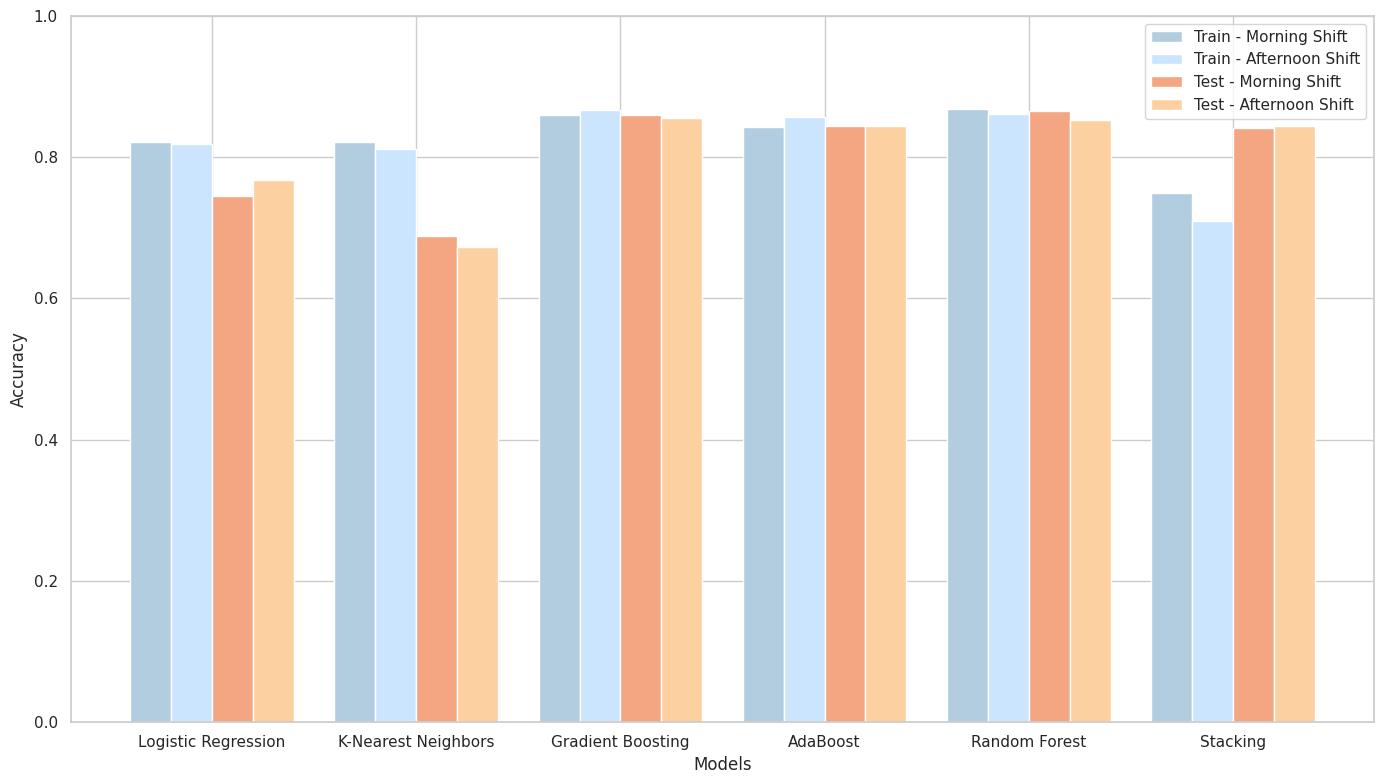

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Logistic Regression', 'K-Nearest Neighbors',
          'Gradient Boosting', 'AdaBoost',
          'Random Forest', 'Stacking']

# Training accuracies
train_morning = [0.8212, 0.8217, 0.8593, 0.8422, 0.8680, 0.7487]
train_afternoon = [0.8186, 0.8121, 0.8676, 0.8575, 0.8606, 0.7098]

# Test accuracies
test_morning = [0.7448, 0.6888, 0.8601, 0.8444, 0.8654, 0.8409]
test_afternoon = [0.7675, 0.6731, 0.8549, 0.8444, 0.8531, 0.8444]

# Setting up the bar width and positions
bar_width = 0.2
index = np.arange(len(models))

# Pastel colors
colors_train_morning = '#b3cde0'  # Pastel blue
colors_train_afternoon = '#cce5ff'  # Lighter pastel blue
colors_test_morning = '#f4a582'  # Pastel orange
colors_test_afternoon = '#fdd0a2'  # Lighter pastel orange

# Plotting the bars
plt.figure(figsize=(14, 8))
plt.bar(index - 1.5 * bar_width, train_morning, bar_width, color=colors_train_morning, label='Train - Morning Shift')
plt.bar(index - 0.5 * bar_width, train_afternoon, bar_width, color=colors_train_afternoon, label='Train - Afternoon Shift')
plt.bar(index + 0.5 * bar_width, test_morning, bar_width, color=colors_test_morning, label='Test - Morning Shift')
plt.bar(index + 1.5 * bar_width, test_afternoon, bar_width, color=colors_test_afternoon, label='Test - Afternoon Shift')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(index, models, rotation=0)
plt.ylim(0, 1)  # Adjust if using percentage
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

# Load the trained models
pipeline_gbm = joblib.load('pipeline_gbm.joblib')
pipeline_ada = joblib.load('pipeline_ada.joblib')
pipeline_rf = joblib.load('pipeline_rf.joblib')
pipeline_stacking = joblib.load('pipeline_stacking.joblib')

# Function to extract top features based on feature importance
def get_top_features(model, X, num_features=10):
    classifier = model.named_steps['classifier']
    if isinstance(classifier, MultiOutputClassifier):
        classifiers = classifier.estimators_
    else:
        classifiers = [classifier]

    top_features = {}
    for i, clf in enumerate(classifiers):
        if hasattr(clf, 'feature_importances_'):
            importances = clf.feature_importances_
            sorted_indices = np.argsort(importances)[::-1]
            top_features[i] = sorted_indices[:num_features]
    return top_features

# Function to get feature names from indices
def get_feature_names(indices, feature_names):
    return [feature_names[idx] for idx in indices]

# Get top 10 features for each model
top_features_gbm = get_top_features(pipeline_gbm, X)
top_features_ada = get_top_features(pipeline_ada, X)
top_features_rf = get_top_features(pipeline_rf, X)

# Since the Stacking Classifier does not provide feature importances directly,
# we will use the top features from the individual models to create the reduced dataset.
top_features_stacking = set()
top_features_stacking.update(top_features_gbm[0])
top_features_stacking.update(top_features_ada[0])
top_features_stacking.update(top_features_rf[0])

# Print top features
def print_top_features(top_features, model_name):
    print(f"\nTop 10 Features for {model_name}:")
    for target, indices in top_features.items():
        print(f"Target {target}:")
        print(", ".join(get_feature_names(indices, X.columns)))

print_top_features(top_features_gbm, "Gradient Boosting Classifier")
print_top_features(top_features_ada, "AdaBoost Classifier")
print_top_features(top_features_rf, "Random Forest Classifier")

# Create reduced datasets with top features
def create_reduced_dataset(X, top_features):
    feature_indices = set()
    for indices in top_features.values():
        feature_indices.update(indices)
    return X.iloc[:, list(feature_indices)]

X_train_gbm_reduced = create_reduced_dataset(X_train, top_features_gbm)
X_test_gbm_reduced = create_reduced_dataset(X_test, top_features_gbm)

X_train_ada_reduced = create_reduced_dataset(X_train, top_features_ada)
X_test_ada_reduced = create_reduced_dataset(X_test, top_features_ada)

X_train_rf_reduced = create_reduced_dataset(X_train, top_features_rf)
X_test_rf_reduced = create_reduced_dataset(X_test, top_features_rf)

# Use the same reduced features for the Stacking Classifier
X_train_stacking_reduced = X_train.iloc[:, list(top_features_stacking)]
X_test_stacking_reduced = X_test.iloc[:, list(top_features_stacking)]

print(f"\nTop Features for Stacking Classifier:\n{', '.join(get_feature_names(list(top_features_stacking), X.columns))}")

# Function to evaluate multi-output models
def evaluate_multioutput_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracies = []
    for i in range(y_test.shape[1]):
        accuracies.append(accuracy_score(y_test.iloc[:, i], y_pred[:, i]))

    average_accuracy = np.mean(accuracies)
    return average_accuracy

# Define models
models = {
    'Gradient Boosting': pipeline_gbm,
    'AdaBoost': pipeline_ada,
    'Random Forest': pipeline_rf,
    'Stacking': pipeline_stacking
}

# Evaluate models on original and reduced feature sets
results_original = {name: evaluate_multioutput_model(model, X_train, y_train, X_test, y_test) for name, model in models.items()}
results_reduced = {
    'Gradient Boosting': evaluate_multioutput_model(pipeline_gbm, X_train_gbm_reduced, y_train, X_test_gbm_reduced, y_test),
    'AdaBoost': evaluate_multioutput_model(pipeline_ada, X_train_ada_reduced, y_train, X_test_ada_reduced, y_test),
    'Random Forest': evaluate_multioutput_model(pipeline_rf, X_train_rf_reduced, y_train, X_test_rf_reduced, y_test),
    'Stacking': evaluate_multioutput_model(pipeline_stacking, X_train_stacking_reduced, y_train, X_test_stacking_reduced, y_test),
}

# Print results
print("\nResults on Original Feature Set:")
for model, accuracy in results_original.items():
    print(f"{model}: {accuracy:.4f}")

print("\nResults on Reduced Feature Set:")
for model, accuracy in results_reduced.items():
    print(f"{model}: {accuracy:.4f}")



Top 10 Features for Gradient Boosting Classifier:
Target 0:
Supervised Session_No_Trainee Assigned_No_Interaction, Internet Issues at Home_Yes, Radiologist ID_R10_Travel Cost (£)_Interaction, Internet Issues at Home_No, Radiologist ID_R10_Supervised Session_No_Interaction, Day_of_Week, Cold Session_Yes_Admin Work_Yes_Interaction, Radiologist ID_R10_Internet Issues at Home_No_Interaction, Radiologist ID_R8_Internet Issues at Home_No_Interaction, Day_of_Month
Target 1:
Supervised Session_No_Trainee Assigned_No_Interaction, Internet Issues at Home_No, Radiologist ID_R10, Radiologist ID_R10_Travel Cost (£)_Interaction, Internet Issues at Home_Yes, Radiologist ID_R8_Admin Work_No_Interaction, Radiologist ID_R10_Internet Issues at Home_No_Interaction, Day_of_Week, Radiologist ID_R3_Travel Cost (£)_Interaction, Radiologist ID_R11_Avg Temp (°C)_Interaction

Top 10 Features for AdaBoost Classifier:
Target 0:
Radiologist ID_R3_Travel Cost (£)_Interaction, Rainfall_travel, Avg_temp_travel, Radio

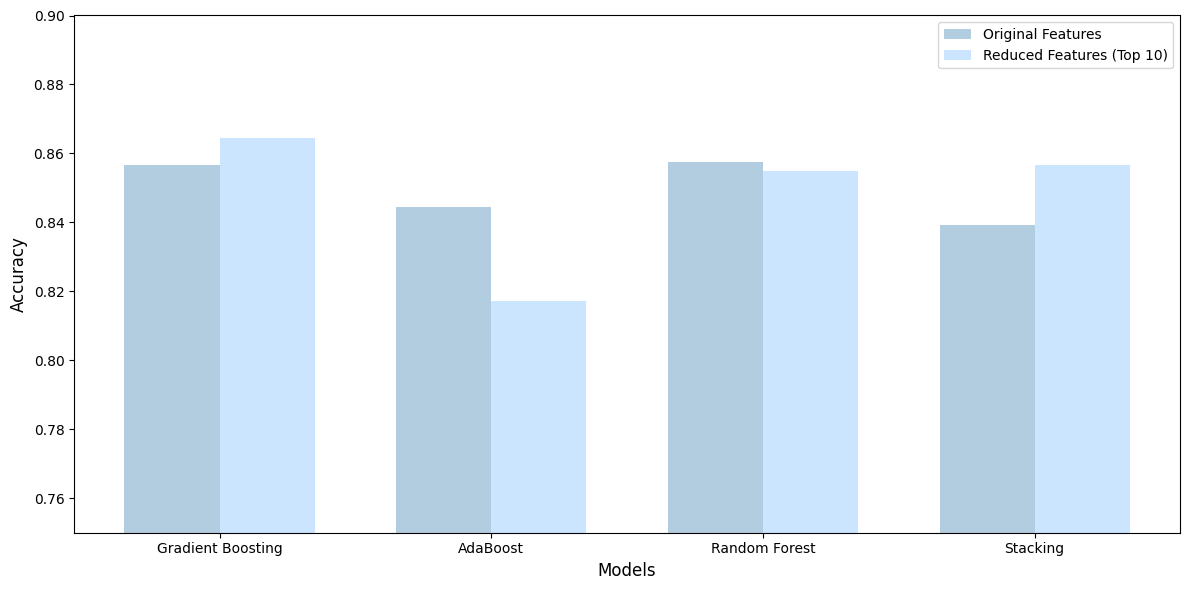

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Gradient Boosting', 'AdaBoost', 'Random Forest', 'Stacking']

# Accuracy on original and reduced feature sets
original_accuracy = [0.8566, 0.8444, 0.8575, 0.8392]
reduced_accuracy = [0.8645, 0.8173, 0.8549, 0.8566]

# Setting up the bar width and positions
bar_width = 0.35
index = np.arange(len(models))

# Plotting the bars
plt.figure(figsize=(12, 6))
plt.bar(index, original_accuracy, bar_width, color='#6495ED', label='Original Features')
plt.bar(index + bar_width, reduced_accuracy, bar_width, color='#FFA07A', label='Reduced Features (Top 10)')

# Adding labels, title, and legend
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracy on Original and Reduced Feature Sets', fontsize=14)
plt.xticks(index + bar_width / 2, models, fontsize=10, rotation=0)
plt.ylim(0.75, 0.90)  # Adjust y-axis range to focus on accuracy differences
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


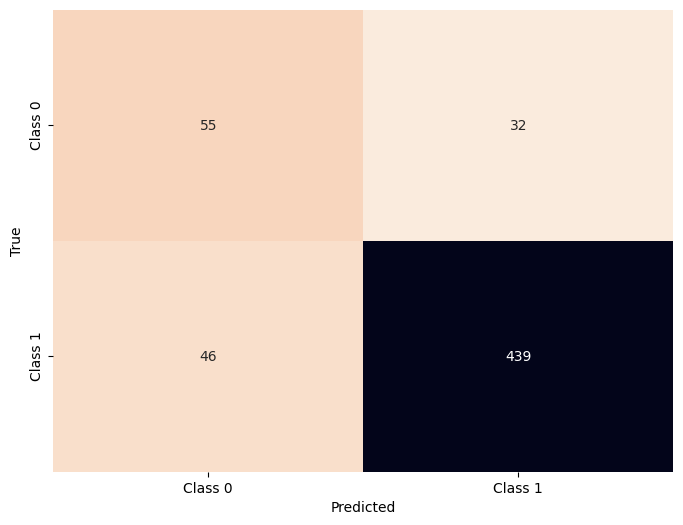

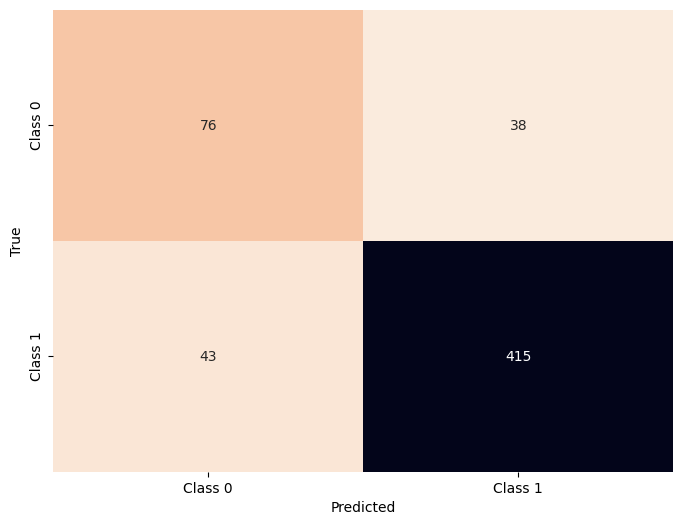

In [26]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the pre-trained Gradient Boosting model pipeline
pipeline_gbm = joblib.load('best_pipeline_gbm.joblib')

# Assume X_test is your test feature set and y_test is your true labels DataFrame
y_pred = pipeline_gbm.predict(X_test)

# y_test is a DataFrame with each column representing a different target variable
target_names = y_test.columns  # List of target variable names
for i, target in enumerate(target_names):
    # Compute confusion matrix for each target variable
    conf_matrix = confusion_matrix(y_test[target], y_pred[:, i])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket_r', cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [ ]:
# Load the model pipeline
pipeline_gbm = joblib.load('best_pipeline_gbm.joblib')

# Load the encoders used in the training phase
internet_issues_encoder = joblib.load('Internet Issues at Home_encoder.pkl')
radiologist_encoder = joblib.load('Radiologist ID_encoder.pkl')
trainee_assigned_encoder = joblib.load('Trainee Assigned_encoder.pkl')
supervised_session_encoder = joblib.load('Supervised Session_encoder.pkl')
cold_session_encoder = joblib.load('Cold Session_encoder.pkl')
admin_work_encoder = joblib.load('Admin Work_encoder.pkl')

# Function to preprocess new input data
def preprocess_input(data):
    # Extract temporal features from 'Date'
    data['Date'] = pd.to_datetime(data['Date'])
    data['Day_of_Week'] = data['Date'].dt.dayofweek
    data['Month'] = data['Date'].dt.month
    data['Day_of_Month'] = data['Date'].dt.day
    data['Quarter'] = data['Date'].dt.quarter
    data['Is_Weekend'] = (data['Date'].dt.dayofweek >= 5).astype(int)

    # Drop the original 'Date' column
    data = data.drop(columns=['Date'])

    # Create interaction features
    data['Month_Rain_Interaction'] = data['Month'] * data['Rainfall (mm)']
    data['Weekend_Travel_Interaction'] = data['Is_Weekend'] * data['Travel Cost (£)']
    data['Rainfall_travel'] = data['Rainfall (mm)'] * data['Travel Cost (£)']
    data['Avg_temp_travel'] = data['Avg Temp (°C)'] * data['Travel Cost (£)']
    data['Weeked_Avg_Temp_Interaction'] = data['Is_Weekend'] * data['Avg Temp (°C)']

    # Encode 'Internet Issues at Home'
    internet_issues_encoded = internet_issues_encoder.transform(data[['Internet Issues at Home']])
    internet_issues_encoded_df = pd.DataFrame(internet_issues_encoded, columns=internet_issues_encoder.get_feature_names_out(['Internet Issues at Home']))

    # Encode 'Radiologist ID'
    radiologist_encoded = radiologist_encoder.transform(data[['Radiologist ID']])
    radiologist_encoded_df = pd.DataFrame(radiologist_encoded, columns=radiologist_encoder.get_feature_names_out(['Radiologist ID']))

    # Encode 'Trainee Assigned'
    trainee_assigned_encoded = trainee_assigned_encoder.transform(data[['Trainee Assigned']])
    trainee_assigned_encoded_df = pd.DataFrame(trainee_assigned_encoded, columns=trainee_assigned_encoder.get_feature_names_out(['Trainee Assigned']))

    # Encode 'Supervised Session'
    supervised_session_encoded = supervised_session_encoder.transform(data[['Supervised Session']])
    supervised_session_encoded_df = pd.DataFrame(supervised_session_encoded, columns=supervised_session_encoder.get_feature_names_out(['Supervised Session']))

    # Encode 'Cold Session'
    cold_session_encoded = cold_session_encoder.transform(data[['Cold Session']])
    cold_session_encoded_df = pd.DataFrame(cold_session_encoded, columns=cold_session_encoder.get_feature_names_out(['Cold Session']))

    # Encode 'Admin Work'
    admin_work_encoded = admin_work_encoder.transform(data[['Admin Work']])
    admin_work_encoded_df = pd.DataFrame(admin_work_encoded, columns=admin_work_encoder.get_feature_names_out(['Admin Work']))

    # Concatenate encoded features back to the original dataframe
    data = pd.concat([data, internet_issues_encoded_df, radiologist_encoded_df, trainee_assigned_encoded_df, supervised_session_encoded_df, cold_session_encoded_df, admin_work_encoded_df], axis=1)

    # Create an empty list to collect DataFrames with interaction features
    interaction_dfs = []

    # For Radiologist encoded columns
    for radiologist_col in radiologist_encoded_df.columns:
        for feature in ['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)', 'Weekend_Travel_Interaction'] + list(internet_issues_encoded_df.columns) + list(supervised_session_encoded_df.columns) + list(admin_work_encoded_df.columns):
            interaction_df = pd.DataFrame({
                f'{radiologist_col}_{feature}_Interaction': radiologist_encoded_df[radiologist_col] * data[feature]
            })
            interaction_dfs.append(interaction_df)

    # For Cold Session encoded columns
    for cold_col in cold_session_encoded_df.columns:
        for feature in list(admin_work_encoded_df.columns) + list(supervised_session_encoded_df.columns) + list(trainee_assigned_encoded_df.columns):
            interaction_df = pd.DataFrame({
                f'{cold_col}_{feature}_Interaction': cold_session_encoded_df[cold_col] * data[feature]
            })
            interaction_dfs.append(interaction_df)

    # For Supervised Session encoded columns
    for supervised_col in supervised_session_encoded_df.columns:
        for feature in ['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)'] + list(admin_work_encoded_df.columns) + list(trainee_assigned_encoded_df.columns):
            interaction_df = pd.DataFrame({
                f'{supervised_col}_{feature}_Interaction': supervised_session_encoded_df[supervised_col] * data[feature]
            })
            interaction_dfs.append(interaction_df)

    # For Admin Work encoded columns
    for admin_col in admin_work_encoded_df.columns:
        for feature in ['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)']+list(internet_issues_encoded_df.columns):
            interaction_df = pd.DataFrame({
                f'{admin_col}_{feature}_Interaction': admin_work_encoded_df[admin_col] * data[feature]
            })
            interaction_dfs.append(interaction_df)

    # Concatenate all interaction DataFrames into one
    interaction_features = pd.concat(interaction_dfs, axis=1)

    # Concatenate interaction features with the original data
    data = pd.concat([data, interaction_features], axis=1)

    # Drop the original categorical columns as they have been encoded
    data = data.drop(columns=['Radiologist ID', 'Internet Issues at Home', 'Trainee Assigned', 'Supervised Session', 'Cold Session', 'Admin Work'])

    return data

# Example input
input_data = pd.DataFrame({
    'Radiologist ID': ['R9'],
    'Date': ['26/07/2024'],
    'Avg Temp (°C)': [12.41],
    'Rainfall (mm)': [14],
    'Travel Cost (£)': [5],
    'Internet Issues at Home': ['No'],
    'Trainee Assigned': ['No'],
    'Supervised Session': ['No'],
    'Cold Session': ['Yes'],
    'Admin Work': ['Yes']
})

# Preprocess the input data
preprocessed_data = preprocess_input(input_data)

# Make a prediction
prediction = pipeline_gbm.predict(preprocessed_data)

# Print the prediction
print("Prediction for Morning Shift Work Locatio n:", prediction[0][0])
print("Prediction for Afternoon Shift Work Location:", prediction[0][1])
